# Leveraging Student Information to Enhance College Persistence

## Part 1: Exploratory Data Analysis

### Step 1: Read the Data

In [17]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_auc_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.inspection import permutation_importance
import scikitplot as skplt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = None

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [18]:
#Read dataset
df = pd.read_excel('data/FY23 data pull.xlsx')
df.head()
df.shape

,Updated ID,High School,HS Grad Year,HS Grad Date,Months Since HS Grad Date,Program Participation,HS GPA Unweighted,HS GPA Weighted,Dual Enrolled,Home Language,ELL/ESL,Gender,Low Income,Race Ethnicity,SAT Composite,ACT Composite,% of scholarships not accepted,Transfer status,2-yr/4-yr start,HS Region,# of scholarships since 2015,Degree Goal,State Preference,Institution Type Preference,First College Enrollment Date,Months Until FCE,First College Name,First College Type,Highest Degree Earned,Highest Degree College Name,Highest Degree Date,First Cert Date,First 2-Year Degree Date,First 4-Year Degree Date,First Advanced Degree Date,2-Year College First Enrollment Date,Months Since First 2-Yr Enrollment,2-Year Degree Date,4-Year Degree Prior to 2-Year Enrollment,4-Year College First Enrollment Date,Months Since First 4-Yr Enrollment,4-Year Degree Date,Time from HS grad to bachelors,6 year BA attainment,8 year BA attainment,Enrollment Indicator Name,Enrollment Indicator,Latest enrollment,Persistence Indicator Name,Persistence Indicator,Completion Indicator Name,Completion Indicator,Associate Completion Indicator Name,Associate Completion Indicator,Bachelors Completion Indicator Name,Bachelors Completion Indicator,Retention Indicator Name,Retention Indicator
0,1,Ida B. Wells Continuation High School,2020,2020-06-01,26,"Scholarship post 2015, Success",NaN,NaN,No,NaN,Not Provided,Female,Yes,Black/African American,NaN,NaN,-67%,No,Never Enrolled,SF Region,2.0,NaN,NaN,NaN,NaT,NaN,Never Enrolled,Never Enrolled,HS,NaN,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaT,No,NaT,NaN,NaT,NaN,NaN,NaN,Enrolled w/in 1 Yr HSG,No,0,Persistence Fall 1 to Fall 2,Ineligible,Completed Any Degree Ever,No,Associate Completion w/in 3 Years,Ineligible,Bachelors Completion w/in 6 Years,Ineligible,Retention Fall 1 to Fall 2,Ineligible
1,2,San Rafael High School,2020,2020-06-01,26,"Scholarship post 2015, Institute, Success",NaN,NaN,No,NaN,Not Provided,Female,Yes,Hispanic/Latino/a/x,NaN,NaN,-60%,No,2-Year,Marin,2.0,NaN,NaN,NaN,2022-01-22,19.677419,College Of Marin,2-Year,HS,NaN,NaT,NaT,NaT,NaT,NaT,2022-01-22,10.0,NaT,No,NaT,NaN,NaT,NaN,NaN,NaN,Enrolled w/in 1 Yr HSG,No,20220822,Persistence Fall 1 to Fall 2,Ineligible,Completed Any Degree Ever,No,Associate Completion w/in 3 Years,Ineligible,Bachelors Completion w/in 6 Years,Ineligible,Retention Fall 1 to Fall 2,Ineligible
2,3,Non-Partner School,2009,2009-06-01,158,"Success, Scholarship",NaN,NaN,No,NaN,Not Provided,Female,Yes,Multiracial/Multiethnic,NaN,NaN,-39%,No,2-Year,Sonoma,4.0,NaN,NaN,NaN,2010-06-14,12.419355,Santa Barbara City College,2-Year,Certificate,Santa Rosa Junior College,2018-05-01,2018-05-01,NaT,NaT,NaT,2010-06-14,149.0,NaT,No,NaT,NaN,NaT,NaN,NaN,NaN,Enrolled w/in 1 Yr HSG,No,20220815,Persistence Fall 1 to Fall 2,Ineligible,Completed Any Degree Ever,Yes,Associate Completion w/in 3 Years,No,Bachelors Completion w/in 6 Years,Ineligible,Retention Fall 1 to Fall 2,Ineligible
3,4,Novato High School,2021,2021-06-01,14,"Scholarship post 2015, Institute",NaN,NaN,No,NaN,Not Provided,Female,Yes,Hispanic/Latino/a/x,NaN,NaN,-100%,No,Never Enrolled,Marin,1.0,NaN,NaN,NaN,NaT,NaN,Never Enrolled,Never Enrolled,HS,NaN,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaT,No,NaT,NaN,NaT,NaN,NaN,NaN,Enrolled w/in 1 Yr HSG,No,0,Persistence Fall 1 to Fall 2,Ineligible,Completed Any Degree Ever,No,Associate Completion w/in 3 Years,Ineligible,Bachelors Completion w/in 6 Years,Ineligible,Retention Fall 1 to Fall 2,Ineligible
4,5,San Rafael High School,2019,2019-06-01,38,"Scholarship post 2015, Institute, Success",NaN,NaN,No,NaN,Not Provided,Female,Yes,Hispanic/Latino/a/x,NaN,NaN,-83%,No,2-Year,Marin,3.0,NaN,NaN,NaN,2019-08-19,2.580645,College Of Marin,2-Year,HS,NaN,NaT,NaT,NaT,NaT,NaT,2019-08-19,39.0,NaT,No,NaT,NaN,NaT,NaN,NaN,NaN,Enrolled w/in 1 Yr HSG,Yes,20190819,Persistence Fall 1 to Fall 2,No,Completed Any Degree Ever,No,Associate Completion w/in 3 Years,No,Bachelors Completion w/in 6 Years,Ineligible,Retention Fall 1 to Fall 2,No


(9945, 58)

In [19]:
#Check the variable type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9945 entries, 0 to 9944
Data columns (total 58 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Updated ID                                9945 non-null   int64         
 1   High School                               9945 non-null   object        
 2   HS Grad Year                              9945 non-null   int64         
 3   HS Grad Date                              9945 non-null   datetime64[ns]
 4   Months Since HS Grad Date                 9945 non-null   int64         
 5   Program Participation                     8337 non-null   object        
 6   HS GPA Unweighted                         0 non-null      float64       
 7   HS GPA Weighted                           0 non-null      float64       
 8   Dual Enrolled                             9945 non-null   object        
 9   Home Language                 

In [20]:
#Check to see if there are any duplicates based on match key
df.shape[0] - df['Updated ID'].nunique()

0

### Step 2: Clean-up the Data

#### Drop columns with no data that can be used for modeling

In [21]:
#Identify columns with all null or just one value
colToDrop = []

for col in list(df.columns):
    if (df[col].nunique() <= 1):
        colToDrop.append(col)
        
colToDrop

['HS GPA Unweighted',
 'HS GPA Weighted',
 'Home Language',
 'ELL/ESL',
 'Low Income',
 'SAT Composite',
 'ACT Composite',
 'Degree Goal',
 'State Preference',
 'Institution Type Preference',
 '6 year BA attainment',
 '8 year BA attainment',
 'Enrollment Indicator Name',
 'Persistence Indicator Name',
 'Completion Indicator Name',
 'Associate Completion Indicator Name',
 'Bachelors Completion Indicator Name',
 'Retention Indicator Name']

In [22]:
#Drop columns from the dataframe
df = df.drop(columns = colToDrop)
df.shape

(9945, 40)

#### Drop records as exclusions per discussions with 10,000 Degrees

10,000 Degrees recommended applying the following exclusions to the data during our initial discussions:

| #     | Variable Name |Description|Exclusion Criteria | Comment |
| :---        |    :----   |    :----   |   :---|   :---|
|1|Persistence Indicator|Indicator to identify students who persisted to the second year of college. This is also the targe variable.|Keep 'Yes' or 'No'|Remove 'Ineligible' students. Some of them took time off before starting college. We do not know if they persisted for their second year of college. They are indeterminates.|
|2|HS Grad Year|High school graduation year|Keep >=2010|Students graduated from high school before 2010 may not have reliable data.|
|3|Program Participation|Participated at any of the programs offered by 10,000 Degrees|Keep records with non-null values |Students with null values applied to a scholarship but were not awarded.|
|4|2-yr/4-yr start|Attended a 2 yr or 4 yr program|Keep records with non-null values |Students with null values have no enrollment information at National Student Clearinghouse (NSC).|

In [23]:
#Keep only records with "Persistence Indicator" is in ['Yes','No']. 
df['Persistence Indicator'].value_counts()

df = df[(df['Persistence Indicator'] == 'Yes') | (df['Persistence Indicator'] == 'No')]

print(f'There are {df.shape[0]} records with Persistence Indicator == "Yes" or "No".')

Ineligible    4955
Yes           4327
No             663
Name: Persistence Indicator, dtype: int64

There are 4990 records with Persistence Indicator == "Yes" or "No".


In [24]:
#Assign 'Persistence Indicator' to 0 (persist) and 1 (drop-out)
df['persistIndicator'] = df['Persistence Indicator'].map(lambda x: 1 if "No" in x else 0)
df['persistIndicator'].value_counts()

0    4327
1     663
Name: persistIndicator, dtype: int64

In [25]:
# Keep records with HS Grad Year >= 2010. Data before 2010 is not reliable.
df = df[(df['HS Grad Year'] >= 2010)]
print(f'There are {df.shape[0]} records with HS Grad Year >= 2010.')

There are 4975 records with HS Grad Year >= 2010.


In [26]:
#Exclude records with null values for Program Participation
df['Program Participation'].isnull().sum()
df = df[df['Program Participation'].isnull() == False]
print(f'There are {df.shape[0]} records with non-null Program Participation.')

312

There are 4663 records with non-null Program Participation.


In [27]:
#Exclude records with null values for 2-yr/4-yr start
df['2-yr/4-yr start'].isnull().sum()
df = df[df['2-yr/4-yr start'].isnull() == False]
print(f'There are {df.shape[0]} records with non-null 2-yr/4-yr start.')

0

There are 4663 records with non-null 2-yr/4-yr start.


### Step 3: Segment the data for 2-year and 4-year students

In [28]:
dfDropOutRate = df.groupby('2-yr/4-yr start')['persistIndicator'].agg(['count','mean']).rename(columns = {"count": "Count","mean":"Dropout Rate"})

In [31]:
dfDropOutRate = dfDropOutRate.iloc[0:2].reset_index()
dfDropOutRate

,index,2-yr/4-yr start,Count,Dropout Rate
0,0,2-Year,2018,0.239346
1,1,4-Year,2644,0.055219


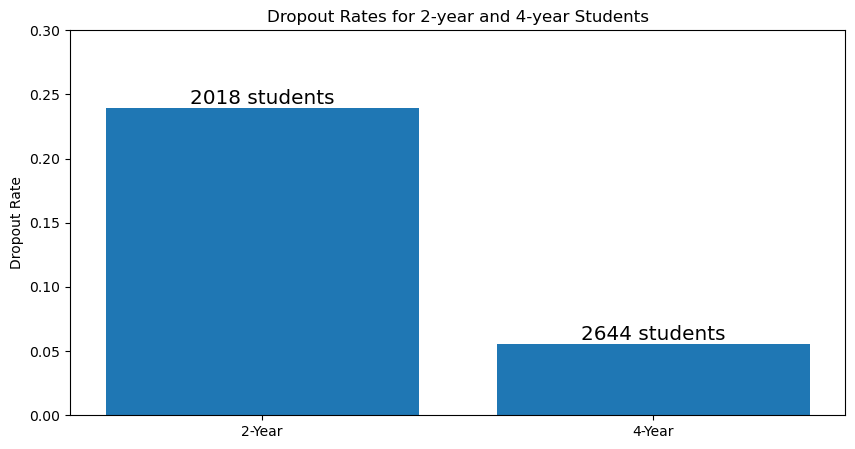

In [32]:
plt.figure(figsize=(10,5))
plt.bar(dfDropOutRate['2-yr/4-yr start'],dfDropOutRate['Dropout Rate']);
plt.ylabel('Dropout Rate')
plt.ylim([0, 0.3])
plt.title('Dropout Rates for 2-year and 4-year Students')

countList = dfDropOutRate['Count'].astype('str').tolist()
labels = [student + ' students' for student in countList]

for i, label in enumerate(labels):
    plt.text(i, dfDropOutRate['Dropout Rate'][i], label, ha='center', va='bottom', fontsize = 'x-large')

plt.show();

- The dropout rate for students attending 2-year college is significantly higher.
- 10,000 Degrees is particularly interested in identifying the factors that impede the persistence of 2-year students to their second year of college.
- This Capstone project is going to focus on the data for 2-year students.

In [33]:
#Keep only records with '2-yr/4-yr start' == 2-Year or Less than 2-Year
df = df[(df['2-yr/4-yr start'] == '2-Year') | (df['2-yr/4-yr start'] == 'Less than 2-Year')]
df.shape

(2019, 41)

## Step 4: Further refinement of the analysis sample based on discussions with 10,000 Degrees

In [34]:
#The emphasis is on students who enroll in college immediately after graduating from high school.
dfHighestDegreeEarned = df.groupby('Highest Degree Earned')['persistIndicator'].agg(['count','mean']).rename(columns = {"count": "Count","mean":"Drop-out Rate"}).reset_index()

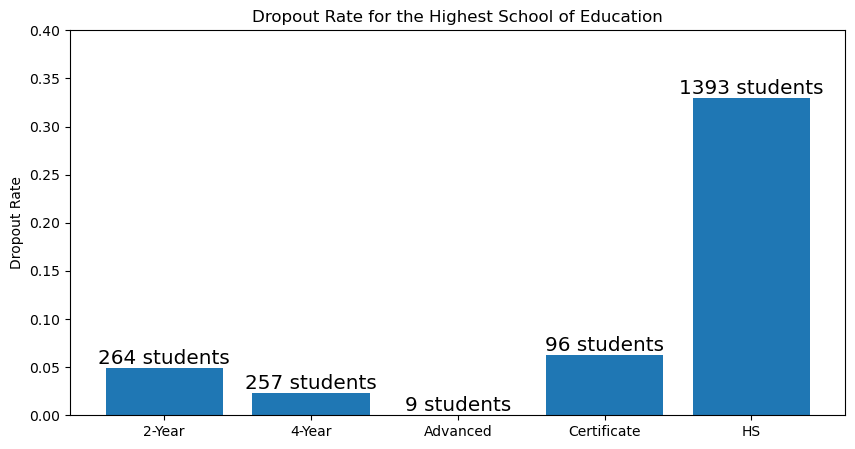

In [35]:
plt.figure(figsize=(10,5))
plt.bar(dfHighestDegreeEarned['Highest Degree Earned'],dfHighestDegreeEarned['Drop-out Rate']);
plt.ylabel('Dropout Rate')
plt.ylim([0, 0.4])
plt.title('Dropout Rate for the Highest School of Education')

countList = dfHighestDegreeEarned['Count'].astype('str').tolist()
labels = [student + ' students' for student in countList]
 
for i, label in enumerate(labels):
    plt.text(i, dfHighestDegreeEarned['Drop-out Rate'][i], label, ha='center', va='bottom', fontsize = 'x-large')

plt.show();

The project will focus on the segment of the population that poses the highest risk of dropping out of college, namely students who transition directly from high school to college.

In [36]:
df =df[df['Highest Degree Earned'] == "HS"]
df.shape

(1393, 41)

In [37]:
#Calculate the final drop-out rate for the analysis sample
dropOutRate = df['persistIndicator'].value_counts(normalize=True)[1]
np.round(dropOutRate,2)

0.33

- Students who enroll directly from high school are at a significantly higher risk of dropping out of college. 
- To improve their chances of success, 10,000 Degrees aims to assess the risk factors associated with these students and implement interventions to support their academic progress.

### Step 4: Feature Engineering

#### Analyze each column to decide on a treatment for 2-Year data

In [38]:
#Function to generate freq and drop-out rate charts
def histCatVariablesCount(i,x,y,t):
    ax[i].bar(x,y)
    ax[i].set_title(t, fontsize = 20, pad = 20.0)
    ax[i].set_ylabel("Number of Students", fontsize = 15)
    ax[i].tick_params(axis = 'x',labelrotation = 45,labelsize = '15')

def histCatVariablesNonPersistenceRate(i,x,y,t):
    ax[i].bar(x,y)
    ax[i].set_title(t, fontsize = 20, pad = 20.0)
    ax[i].set_ylabel("Dropout Rate", fontsize = 15)
    ax[i].tick_params(axis = 'x',labelrotation= 45,labelsize = '15')
    ax[i].axhline(y = dropOutRate, color = 'r')
    ax[i].text(0, 0.34, "Average Dropout Rate", fontsize = 15)

In [39]:
#List of columns that will be analyzed in this section
list(df.columns)

['Updated ID',
 'High School',
 'HS Grad Year',
 'HS Grad Date',
 'Months Since HS Grad Date',
 'Program Participation',
 'Dual Enrolled',
 'Gender',
 'Race Ethnicity',
 '% of scholarships not accepted',
 'Transfer status',
 '2-yr/4-yr start',
 'HS Region',
 '# of scholarships since 2015',
 'First College Enrollment Date',
 'Months Until FCE',
 'First College Name',
 'First College Type',
 'Highest Degree Earned',
 'Highest Degree College Name',
 'Highest Degree Date',
 'First Cert Date',
 'First 2-Year Degree Date',
 'First 4-Year Degree Date',
 'First Advanced Degree Date',
 '2-Year College First Enrollment Date',
 'Months Since First 2-Yr Enrollment',
 '2-Year Degree Date',
 '4-Year Degree Prior to 2-Year Enrollment',
 '4-Year College First Enrollment Date',
 'Months Since First 4-Yr Enrollment',
 '4-Year Degree Date',
 'Time from HS grad to bachelors',
 'Enrollment Indicator',
 'Latest enrollment',
 'Persistence Indicator',
 'Completion Indicator',
 'Associate Completion Indicator'

#### High School 

In [40]:
#Create a function to web scrape school ratings from greatschools.org website using BeautifulSoup
import requests
from bs4 import BeautifulSoup

def get_school_rating(school_name):
    url = f'https://www.greatschools.org/search/search.page?q={school_name}'
    response = requests.get(url, verify = False)
    html_data = response.text

    soup = BeautifulSoup(html_data, 'html.parser')
    cdata = soup.find('script')

    cdata_str = str(cdata)
    start = cdata_str.find('"rating":') + len('"rating":')
    end = cdata_str.find(',', start)
    rating = cdata_str[start:end].strip()
    if rating:
        return rating
    else:
        return "School not found"

In [41]:
#Create a unique list of high school names and their web addresses according to greatschools.org format
schoolList = list(df['High School'].unique())

formattedSchoolList = []

for school in schoolList:
    formattedSchool = "%22" + school.replace(" ","%20") +"%22" #Standard website link for each school name
    formattedSchoolList.append(formattedSchool)
    
schoolListDict = dict(zip(schoolList,formattedSchoolList))

In [42]:
#Create a dataframe with school names, websites and ratings.
schools = []
schoolsWebAddress = []
ratings = []

for key, value in schoolListDict.items():
    schools.append(key)
    schoolsWebAddress.append("https://www.greatschools.org/search/search.page?q="+value)
    rating = get_school_rating(value)
    if rating == "null": #The school does not have a rating
        rating = -1
    elif rating == '//<![CDATA[\nwindow.gon={};gon.ad_set_targeting={"env":"prod"': #The link is not working
        rating = -2
    else:
        rating = int(rating)-1
    rating = str(rating)
    ratings.append(rating)

dfSchoolRating = pd.DataFrame({'School': schools, 'Web Address': schoolsWebAddress, 'HSRating': ratings})
dfSchoolRating.to_csv('data/HighSchoolRatingFromGreatSchoolsWebsite.csv')

- Due to some high schools' website links not conforming to the standard format for GreatSchools.org, I had to search for their ratings manually and update them.
- Subsequently, I saved the modified file as HighSchoolRating.csv.

In [43]:
dfSchoolRating2 = pd.read_csv('data/HighSchoolRating.csv',dtype = {'HSRating':'string'})
dfSchoolRating2
dfSchoolRating2.shape

,School,Web Address,HSRating_WebScrap,HSRating
0,"Abraham Lincoln High School (San Francisco, CA)",https://www.greatschools.org/search/search.pag...,-2,6
1,"Abraham Lincoln High School (San Jose, CA)",https://www.greatschools.org/search/search.pag...,-2,5
2,Adult Education Program,https://www.greatschools.org/search/search.pag...,-1,2
3,Alief Hastings High School,https://www.greatschools.org/search/search.pag...,-2,2
4,Amistad High School,https://www.greatschools.org/search/search.pag...,-2,2
...,...,...,...,...
125,Wallenberg (Raoul) Traditional High,https://www.greatschools.org/search/search.pag...,7,7
126,Watsonville High School,https://www.greatschools.org/search/search.pag...,1,1
127,William C. Overfelt High School,https://www.greatschools.org/search/search.pag...,2,2
128,Windsor High School,https://www.greatschools.org/search/search.pag...,4,4


(130, 4)

In [44]:
#There are two types of webscraping errors, -1 and -2 defined in the webscrape function def get_school_rating(school_name).
#I simplified it to -1 to be able to use the high school rating in model development.
dfSchoolRating2['HSRating2'] = np.where((dfSchoolRating2['HSRating'] == "-1") | (dfSchoolRating2['HSRating'] == "-2"), "-1", dfSchoolRating2['HSRating'])
dfSchoolRating2.head

<bound method NDFrame.head of                                               School  \
0    Abraham Lincoln High School (San Francisco, CA)   
1         Abraham Lincoln High School (San Jose, CA)   
2                            Adult Education Program   
3                         Alief Hastings High School   
4                                Amistad High School   
..                                               ...   
125              Wallenberg (Raoul) Traditional High   
126                          Watsonville High School   
127                  William C. Overfelt High School   
128                              Windsor High School   
129                          Yerba Buena High School   

                                           Web Address  HSRating_WebScrap  \
0    https://www.greatschools.org/search/search.pag...                 -2   
1    https://www.greatschools.org/search/search.pag...                 -2   
2    https://www.greatschools.org/search/search.pag...            

In [45]:
#Merge df with dfSchoolRating to get their HS school rating by doing a left join
df = pd.merge(left = df, right = dfSchoolRating2[['School','HSRating2']], left_on = 'High School', right_on = 'School', how = 'left').drop(columns = ['School'])
df.head()

,Updated ID,High School,HS Grad Year,HS Grad Date,Months Since HS Grad Date,Program Participation,Dual Enrolled,Gender,Race Ethnicity,% of scholarships not accepted,Transfer status,2-yr/4-yr start,HS Region,# of scholarships since 2015,First College Enrollment Date,Months Until FCE,First College Name,First College Type,Highest Degree Earned,Highest Degree College Name,Highest Degree Date,First Cert Date,First 2-Year Degree Date,First 4-Year Degree Date,First Advanced Degree Date,2-Year College First Enrollment Date,Months Since First 2-Yr Enrollment,2-Year Degree Date,4-Year Degree Prior to 2-Year Enrollment,4-Year College First Enrollment Date,Months Since First 4-Yr Enrollment,4-Year Degree Date,Time from HS grad to bachelors,Enrollment Indicator,Latest enrollment,Persistence Indicator,Completion Indicator,Associate Completion Indicator,Bachelors Completion Indicator,Retention Indicator,persistIndicator,HSRating2
0,5,San Rafael High School,2019,2019-06-01,38,"Scholarship post 2015, Institute, Success",No,Female,Hispanic/Latino/a/x,-83%,No,2-Year,Marin,3.0,2019-08-19,2.580645,College Of Marin,2-Year,HS,NaN,NaT,NaT,NaT,NaT,NaT,2019-08-19,39.0,NaT,No,NaT,NaN,NaT,NaN,Yes,20190819,No,No,No,Ineligible,No,1,3
1,13,Novato High School,2021,2021-06-01,14,"Scholarship post 2015, METAS",No,Female,Hispanic/Latino/a/x,-100%,No,2-Year,Marin,1.0,2021-08-16,2.483871,Santa Rosa Junior College,2-Year,HS,NaN,NaT,NaT,NaT,NaT,NaT,2021-08-16,15.0,NaT,No,NaT,NaN,NaT,NaN,Yes,20220822,Yes,No,Ineligible,Ineligible,No,0,6
2,15,Novato High School,2020,2020-06-01,26,"Scholarship post 2015, Success, METAS",No,Male,Hispanic/Latino/a/x,-50%,No,2-Year,Marin,2.0,2020-08-17,2.516129,Santa Rosa Junior College,2-Year,HS,NaN,NaT,NaT,NaT,NaT,NaT,2020-08-17,27.0,NaT,No,NaT,NaN,NaT,NaN,Yes,20210816,No,No,Ineligible,Ineligible,No,1,6
3,18,Novato High School,2019,2019-06-01,38,"Scholarship post 2015, Institute, Success",No,Male,Asian,-34%,Transfer,2-Year,Marin,3.0,2019-08-19,2.580645,Santa Rosa Junior College,2-Year,HS,NaN,NaT,NaT,NaT,NaT,NaT,2019-08-19,39.0,NaT,No,2022-09-21,2.0,NaT,NaN,Yes,20220921,Yes,No,No,Ineligible,Yes,0,6
4,20,Novato High School,2019,2019-06-01,38,"Scholarship post 2015, Institute, Success, METAS",No,Female,Hispanic/Latino/a/x,-17%,Transfer,2-Year,Marin,3.0,2019-08-19,2.580645,Santa Rosa Junior College,2-Year,HS,NaN,NaT,NaT,NaT,NaT,NaT,2019-08-19,39.0,NaT,No,2022-08-29,3.0,NaT,NaN,Yes,20220829,Yes,No,No,Ineligible,Yes,0,6


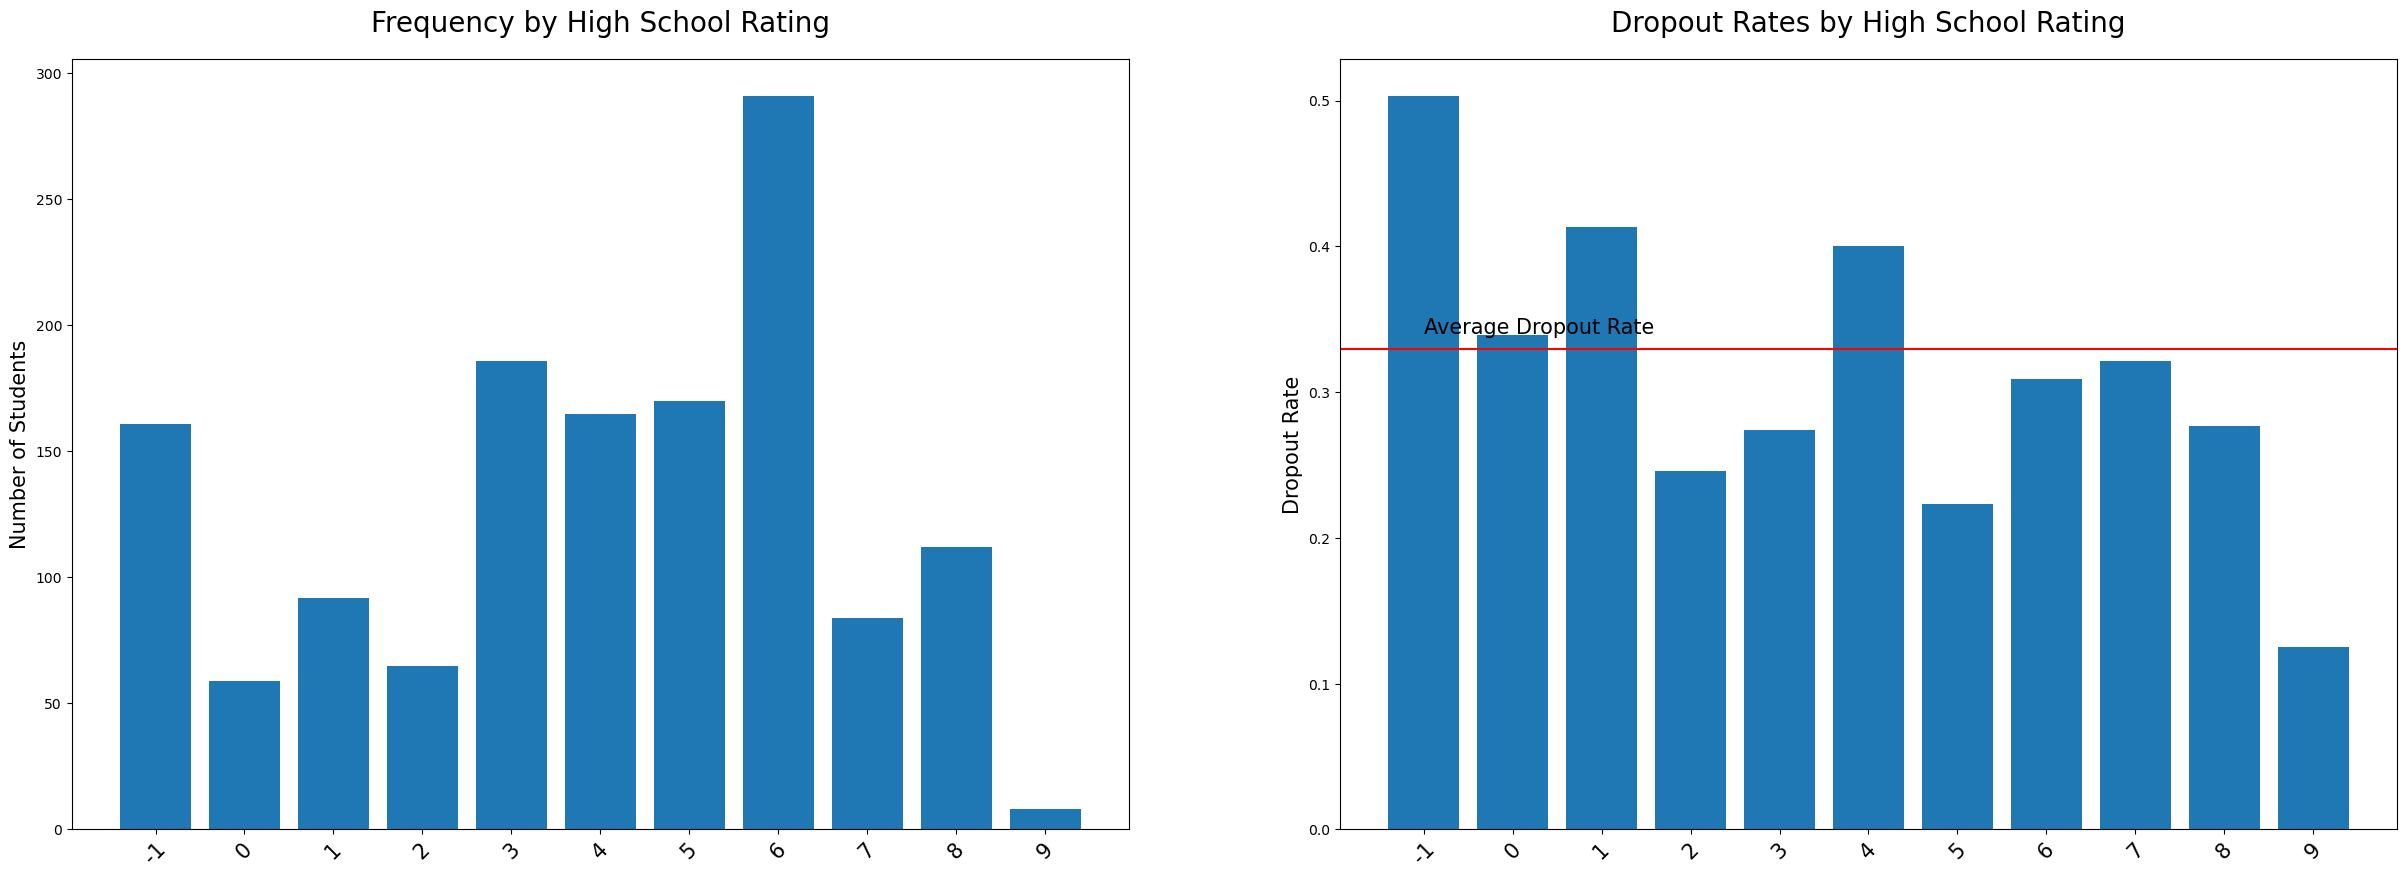

In [46]:
dfHSRatingCount = pd.DataFrame(df.groupby("HSRating2")['persistIndicator'].agg('count')).reset_index()
dfHSRatingAvg = pd.DataFrame(df.groupby("HSRating2")['persistIndicator'].agg('mean')).reset_index()

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfHSRatingCount.HSRating2,dfHSRatingCount.persistIndicator,"Frequency by High School Rating")
histCatVariablesNonPersistenceRate(1,dfHSRatingAvg.HSRating2,dfHSRatingAvg.persistIndicator,"Dropout Rates by High School Rating")

#### Summary of Findings for <u>High School</u>:
- Students who attended schools with higher ratings tend to have lower dropout rates.

<u>Action</u>:

- Drop 'High School' but keep the corresponding rating for model development.

####  'HS Grad Year', 'HS Grad Date' and 'Months Since HS Grad Date'

Check to see if these three columns carry the same information

In [47]:
#Check to see if there is 100% overlap between HS Grad Year and HS Grad Date
pd.pivot_table(df, index= 'HS Grad Year', columns = 'HS Grad Date', aggfunc = 'count')['Updated ID'].replace({np.nan:0}).astype(int).replace({0:""})

HS Grad Date,2010-06-01,2011-06-01,2012-06-01,2013-06-01,2014-06-01,2015-06-01,2016-06-01,2017-06-01,2018-06-01,2019-06-01,2020-06-01,2021-06-01
HS Grad Year,,,,,,,,,,,,
2010,7,,,,,,,,,,,
2011,,17,,,,,,,,,,
2012,,,23,,,,,,,,,
2013,,,,45,,,,,,,,
2014,,,,,49,,,,,,,
2015,,,,,,52,,,,,,
2016,,,,,,,61,,,,,
2017,,,,,,,,84,,,,
2018,,,,,,,,,137,,,


All the counts are on the diagonal. These two fields overlap 100%.

In [48]:
#Check to see if there is 100% overlap between HS Date and Months Since HS Grad Date
pd.pivot_table(df, index= 'HS Grad Date', columns = 'Months Since HS Grad Date', aggfunc = 'count')['Updated ID'].replace({np.nan:0}).astype(int).replace({0:""})

Months Since HS Grad Date,14,26,38,50,62,74,86,98,110,122,134,146
HS Grad Date,,,,,,,,,,,,
2010-06-01,,,,,,,,,,,,7
2011-06-01,,,,,,,,,,,17,
2012-06-01,,,,,,,,,,23,,
2013-06-01,,,,,,,,,45,,,
2014-06-01,,,,,,,,49,,,,
2015-06-01,,,,,,,52,,,,,
2016-06-01,,,,,,61,,,,,,
2017-06-01,,,,,84,,,,,,,
2018-06-01,,,,137,,,,,,,,


All the counts are on the diagonal. These two fields overlap 100%.

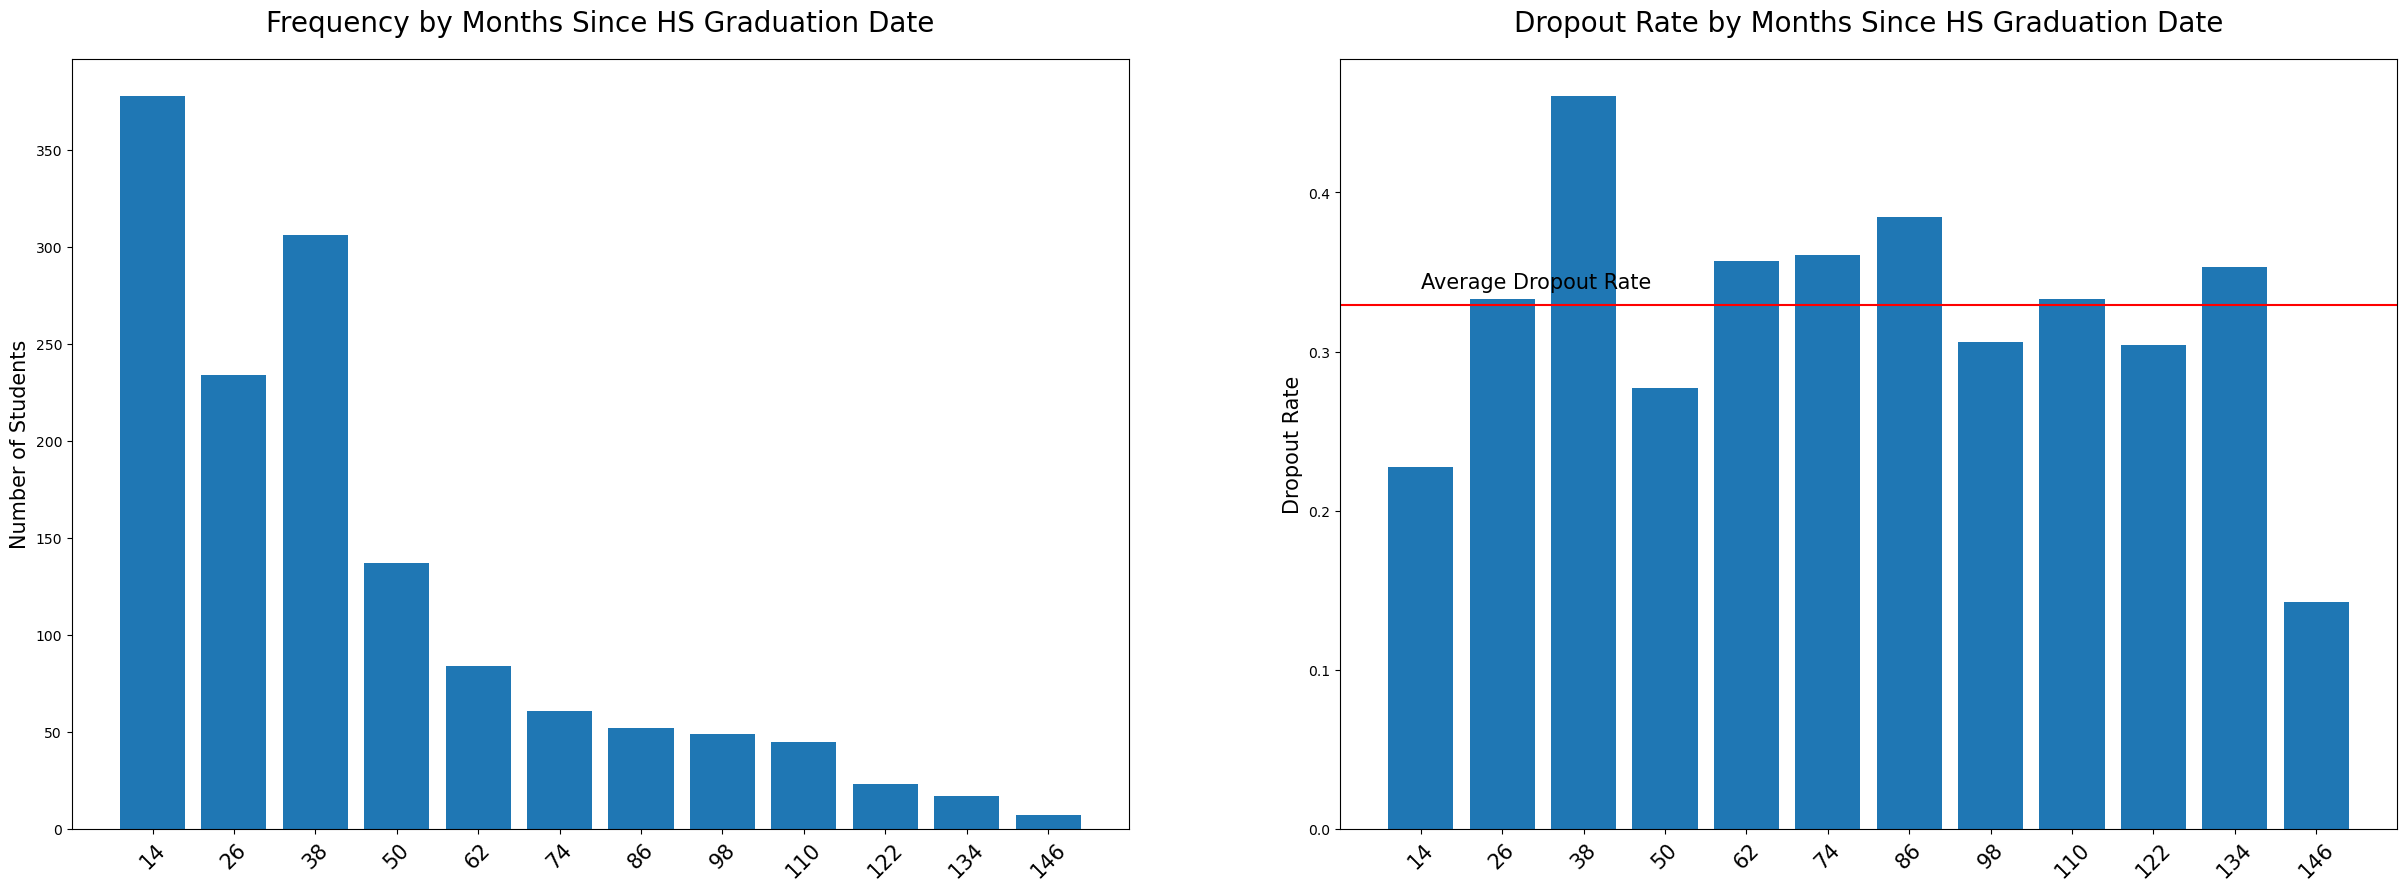

In [49]:
#Check to see trend of the dropout rate for'Months Since HS Grade Date'
dfMonthsSinceHSCount = pd.DataFrame(df.groupby("Months Since HS Grad Date")['persistIndicator'].agg('count')).reset_index()
dfMonthsSinceHSAvg = pd.DataFrame(df.groupby("Months Since HS Grad Date")['persistIndicator'].agg('mean')).reset_index()

dfMonthsSinceHSCount['Months Since HS Grad Date'] = dfMonthsSinceHSCount['Months Since HS Grad Date'].astype('str')
dfMonthsSinceHSAvg['Months Since HS Grad Date'] = dfMonthsSinceHSAvg['Months Since HS Grad Date'].astype('str')

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfMonthsSinceHSCount['Months Since HS Grad Date'],dfMonthsSinceHSCount.persistIndicator,"Frequency by Months Since HS Graduation Date")
histCatVariablesNonPersistenceRate(1,dfMonthsSinceHSAvg['Months Since HS Grad Date'],dfMonthsSinceHSAvg.persistIndicator,"Dropout Rate by Months Since HS Graduation Date")

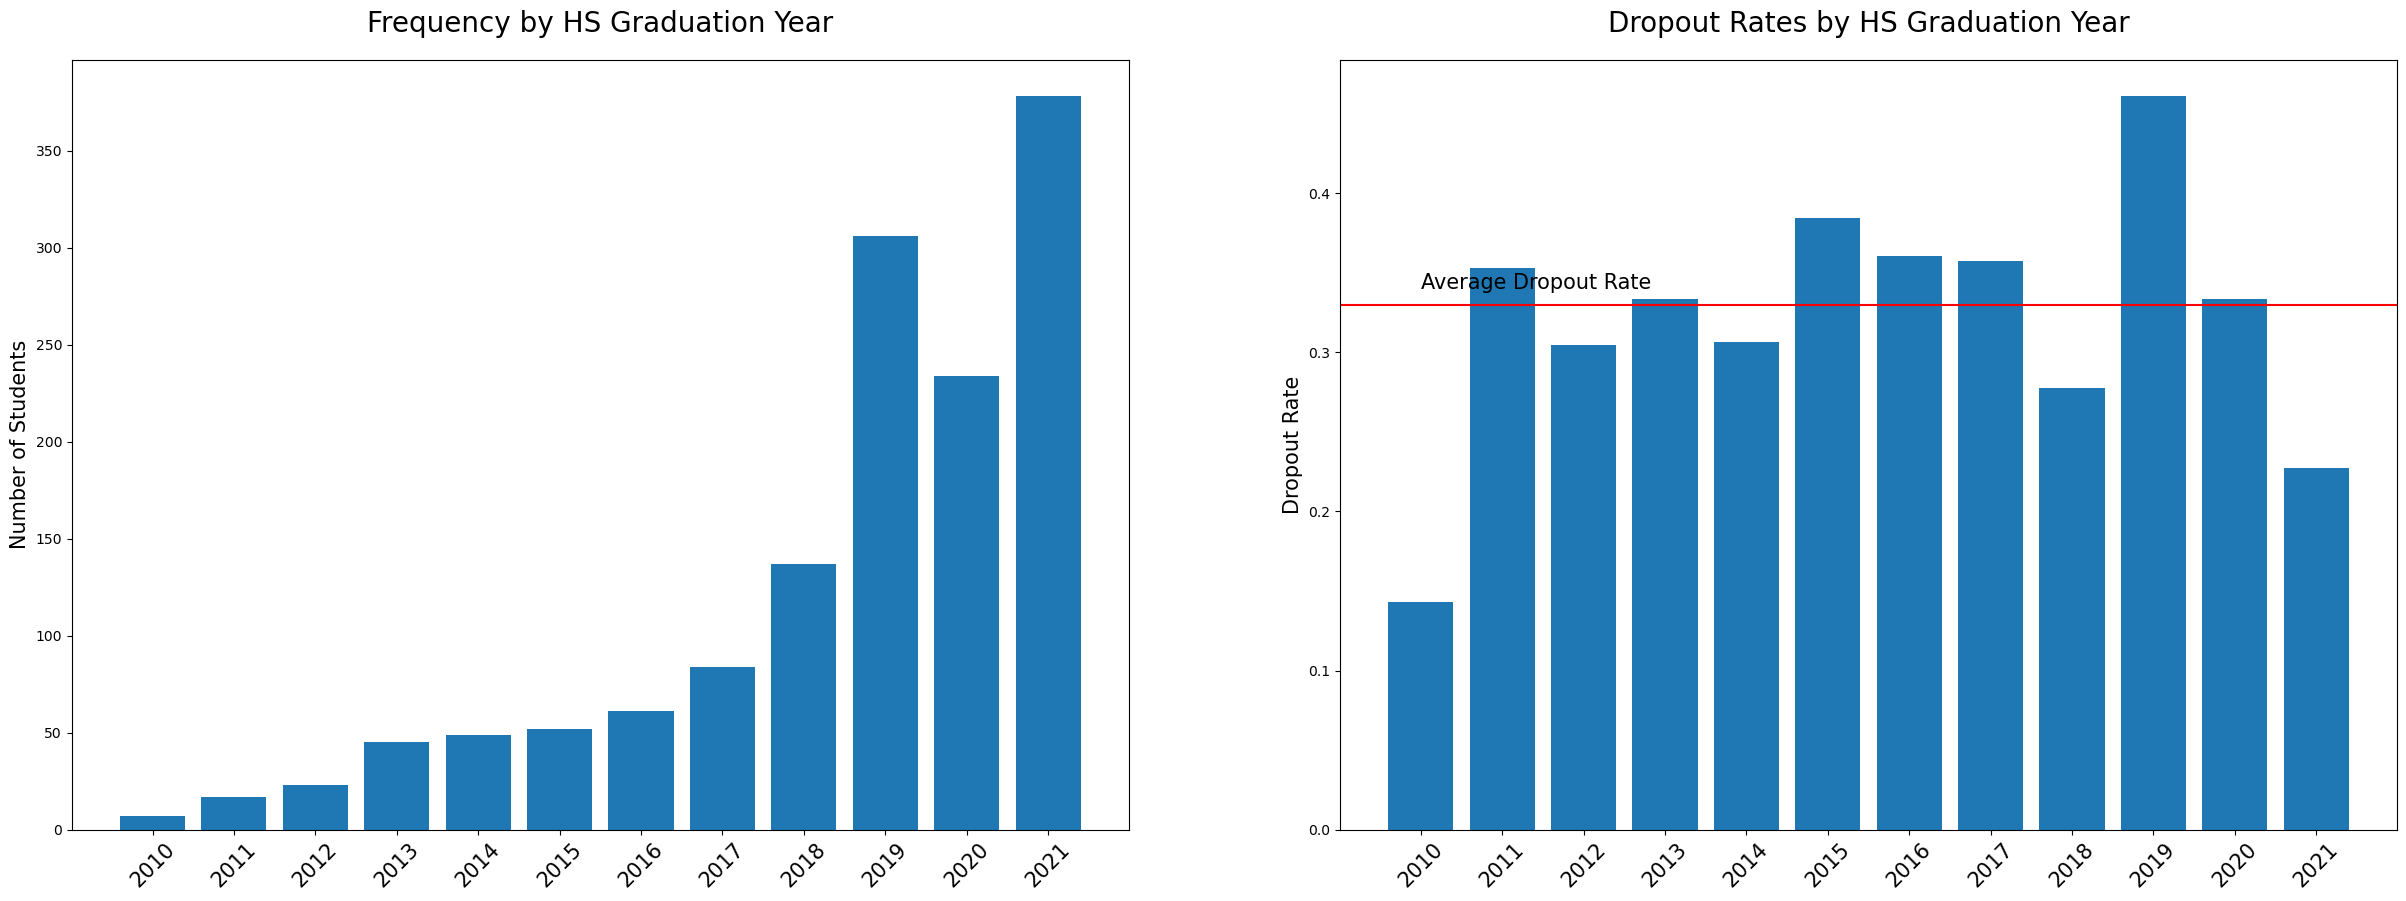

In [50]:
#Check to see trend of the drop-out rate for'Months Since HS Grade Date'
dfMonthsSinceHSCount = pd.DataFrame(df.groupby("HS Grad Year")['persistIndicator'].agg('count')).reset_index()
dfMonthsSinceHSAvg = pd.DataFrame(df.groupby("HS Grad Year")['persistIndicator'].agg('mean')).reset_index()

dfMonthsSinceHSCount['HS Grad Year'] = dfMonthsSinceHSCount['HS Grad Year'].astype('str')
dfMonthsSinceHSAvg['HS Grad Year'] = dfMonthsSinceHSAvg['HS Grad Year'].astype('str')

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfMonthsSinceHSCount['HS Grad Year'],dfMonthsSinceHSCount.persistIndicator,"Frequency by HS Graduation Year")
histCatVariablesNonPersistenceRate(1,dfMonthsSinceHSAvg['HS Grad Year'],dfMonthsSinceHSAvg.persistIndicator,"Dropout Rates by HS Graduation Year")

#### Summary of Findings for <u>HS Grad Year</u>, <u>HS Grad Date</u> and <u>Months Since High School Graduation</u> :
- These three variables contain identical information.
- Students who graduated from high school in 2019 have a higher drop-out rate, which 10,000 Degrees has confirmed is related to Covid-19. 
- Since we have a limited number of observations, we have decided to retain these records in the development sample. However, once we have a larger sample size, we may consider excluding Covid-related data from the sample.

<u>Action</u>:

- Drop 'HS Grad Year','HS Grad Date' and 'Months Since High School Graduation'.

####  'Program Participation'

In [51]:
df['Program Participation'].value_counts(dropna = False)

Scholarship post 2015, Institute, Success           387
Scholarship post 2015                               308
Success                                             203
Scholarship                                         151
Scholarship post 2015, Institute                    109
Success, Scholarship                                 59
Scholarship post 2015, Success                       39
Scholarship post 2015, Success, METAS                20
Institute                                            20
METAS                                                14
Institute, Success, Scholarship                      14
Scholarship post 2015, METAS                         11
Institute, Success, Scholarship post 2010            11
Scholarship post 2015, Institute, Success, METAS      8
ECCA                                                  7
Institute, Scholarship                                6
Scholarship post 2015, Institute, ECCA                4
Institute, Success                              

Below programs are offered by 10,000 Degrees:

| #     | Program |Student Type|Description|
| :---        |    :----   |    :----   |   :----   |
|1|METAS|High school|Program offered by 10,000 Degrees in Marin for students in English as a Second Language (ESL) classes|
|2|ECCA|High school |Program offered by 10,000 Degrees in Marin but not limited to ESL students|
|3|Institute|High school|Program done in summer before the senior year in high school |
|4|Meritus|College|Scholarship and college support from another program that merged with 10,000 Degrees|
|5|Success|College|College support program|
|6|Scholarship|College|Scholarship program|

Some students may have participated to multiple programs.

In [52]:
#Create a new column for METAS participants
df["ESL"] = df["Program Participation"].map(lambda x: 1 if "METAS" in x else 0)
df["ESL"].value_counts(dropna = False)
df.groupby("ESL")['persistIndicator'].mean().round(3)

0    1331
1      62
Name: ESL, dtype: int64

ESL
0    0.328
1    0.355
Name: persistIndicator, dtype: float64

- The students enrolled in the METAS program are primarily English as a Second Language (ESL) students, many of whom come from disadvantaged families.
- The fact that they have a high dropout rate is indicative of their vulnerability. 
- The data from METAS could be utilized to develop a vulnerability index that would enable us to identify these students with disadvantaged backgrounds more effectively.

In [53]:
#Create a new column for ECCA participants
df["ECCA"] = df["Program Participation"].map(lambda x: 1 if "ECCA" in x else 0)
df["ECCA"].value_counts(dropna = False)
df.groupby("ECCA")['persistIndicator'].mean().round(3)

0    1380
1      13
Name: ECCA, dtype: int64

ECCA
0    0.330
1    0.231
Name: persistIndicator, dtype: float64

- Students who participated in the ECCA program during their high school years demonstrate a lower dropout rate during their second year of college.

In [54]:
#Create a new column for Institute participants
df["Institute"] = df["Program Participation"].map(lambda x: 1 if "Institute" in x else 0)
df["Institute"].value_counts(dropna = False)
df.groupby("Institute")['persistIndicator'].mean().round(3)

0    823
1    570
Name: Institute, dtype: int64

Institute
0    0.337
1    0.319
Name: persistIndicator, dtype: float64

- Students who take part in the Institute program during the summer following their high school graduation and before commencing college have a lower dropout rate in their second year of college.

In [55]:
#Create a new column for Meritus participants
df["Meritus"] = df["Program Participation"].map(lambda x: 1 if "Meritus" in x else 0)
df["Meritus"].value_counts(dropna = False)
df.groupby('Meritus')['persistIndicator'].mean().round(3)

0    1391
1       2
Name: Meritus, dtype: int64

Meritus
0    0.33
1    0.00
Name: persistIndicator, dtype: float64

- There are only two students who originated from the Meritus program, which has been discontinued and will not be available in the future.
- Consequently, we will not include this variable in our model development.

In [56]:
#Create a new column for Success and Scholarship participants
#According to 10,000 Degrees, students who took part in the Success program with and without scholarships are expected to exhibit varying rates of dropout.
df["Success"] = df["Program Participation"].map(lambda x: 1 if "Success" in x else 0)
df["Scholarship"] = df["Program Participation"].map(lambda x: 1 if "Scholarship" in x else 0)

In [57]:
pd.pivot_table(df, index= 'Success', columns = 'Scholarship', aggfunc = 'count')['Updated ID'].replace({np.nan:""})
pd.pivot_table(df, index= 'Success', columns = 'Scholarship', aggfunc = 'mean')['persistIndicator'].replace({np.nan:""}).round(3)

Scholarship,0,1
Success,,
0,43,597
1,210,543


Scholarship,0,1
Success,,
0,0.279,0.276
1,0.481,0.333


In [58]:
def success(s):
    if ((s['Success'] == 1) and (s['Scholarship'] == 1)):
        return "Success with Scholarship" #Attended Success with scholarship
    elif ((s['Success'] == 1) and (s['Scholarship'] == 0)):
        return "Success without Scholarship" #Attended Success with scholarship
    elif ((s['Success'] == 0) and (s['Scholarship'] == 0)):
        return "Neither Success nor Scholarship" #No Success and no Scholarship
    elif ((s['Success'] == 0) and (s['Scholarship'] == 1)):
        return "No Success but Scholarship" #Scholarship but no Success
    else:
        return "Error" #Error

df['successScholarship'] = df.apply(success, axis=1)

df['successScholarship'].value_counts()
df.groupby("successScholarship")['persistIndicator'].mean().round(3)

No Success but Scholarship         597
Success with Scholarship           543
Success without Scholarship        210
Neither Success nor Scholarship     43
Name: successScholarship, dtype: int64

successScholarship
Neither Success nor Scholarship    0.279
No Success but Scholarship         0.276
Success with Scholarship           0.333
Success without Scholarship        0.481
Name: persistIndicator, dtype: float64

In [59]:
#Create a numeric success/scholarship variable
#Students who did not attended Success is one category
#Students who attended the Success program will be split into two categories: With Scholarship, and without Scholarship
successScholarshipDict = {'Neither Success nor Scholarship':1,
            'No Success but Scholarship':1,
            'Success with Scholarship':2,
            'Success without Scholarship':3}

df['successScholarshipParticipant'] =df['successScholarship'].map(successScholarshipDict)

- Students who receive a scholarship through the Success program demonstrate greater persistence than their counterparts who only attended the Success program.
- There appears to be a higher level of persistence among students who did not participate in the Success program, and we are currently engaging in discussions with 10,000 Degrees to gain a deeper understanding of this finding.

#### Summary of Findings for <u>Program Participation</u>
- METAS, ECCA and Institute are all high school programs. 
- Meritus, Success and Scholarship are college programs.
    - Meritus program has been discontinued.
    - Success students who got Scholarship have a lower dropout rate.
    - It is surprising to note that students who did not participate in the Success program have a lower dropout rate. This goes against what we might expect and we are currently awaiting a response from 10,000 Degrees in order to better understand the underlying reasons behind this phenomenon.

<u>Action</u>:

- Create three separate columns for METAS for ESL, ECCA and Institute attendance during high school education.
- Create a column that merges the data from both the Success and Scholarship programs. Students who did not participate in the Success program will be a separate category. For those who did attend the Success program, we will split them into two groups: those who received scholarships and those who did not.

####  'Dual Enrolled'

Students sign up in the community college classes while they are finishing high-school.

In [60]:
df['Dual Enrolled'].value_counts(dropna = False)
df.groupby('Dual Enrolled')['persistIndicator'].mean()

No     1380
Yes      13
Name: Dual Enrolled, dtype: int64

Dual Enrolled
No     0.331884
Yes    0.076923
Name: persistIndicator, dtype: float64

Dual enrolled students are less likely to dropout.

In [61]:
#Convert to numeric
df['dualEnrolled'] = df["Dual Enrolled"].map(lambda x: 1 if "Yes" in x else 0)
df['dualEnrolled'].value_counts()

0    1380
1      13
Name: dualEnrolled, dtype: int64

In [62]:
dfDualEnrolled = df.groupby('Dual Enrolled')['persistIndicator'].agg(['count','mean']).rename(columns = {"count": "Count","mean":"Dropout Rate"}).reset_index().round(3)
dfDualEnrolled

,Dual Enrolled,Count,Dropout Rate
0,No,1380,0.332
1,Yes,13,0.077


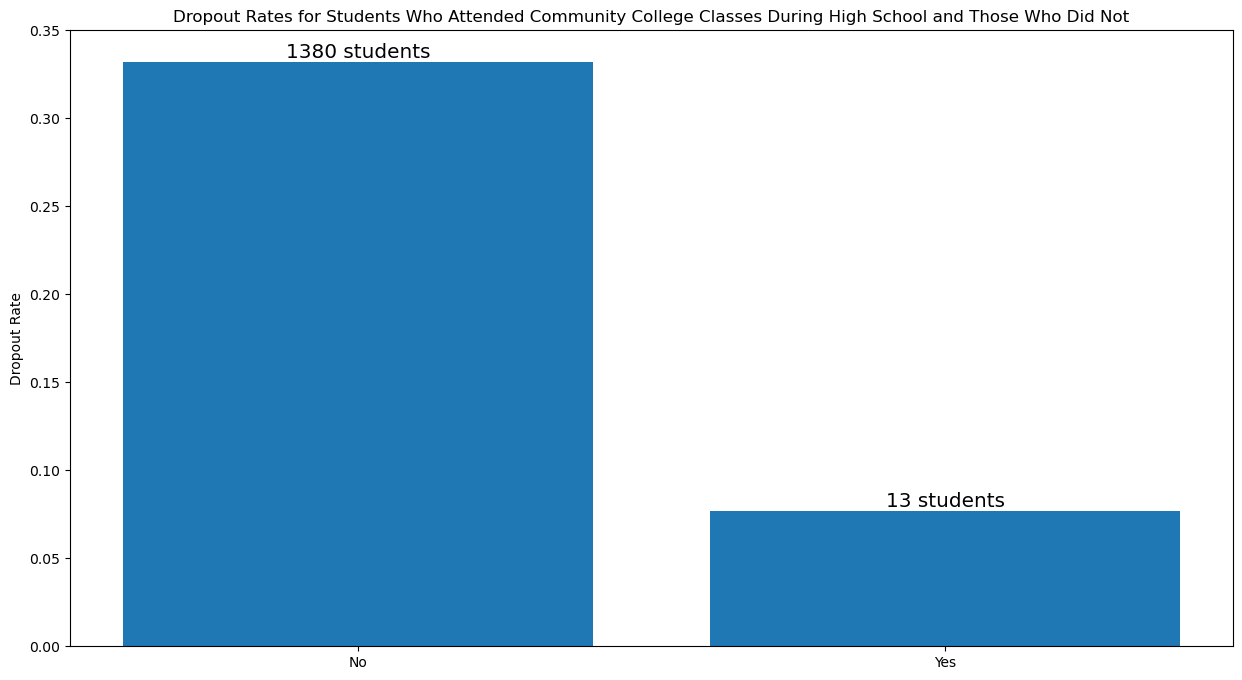

In [63]:
plt.figure(figsize=(15,8))
plt.bar(dfDualEnrolled['Dual Enrolled'],dfDualEnrolled['Dropout Rate']);
plt.ylabel('Dropout Rate')
plt.ylim([0, 0.35])
plt.title('Dropout Rates for Students Who Attended Community College Classes During High School and Those Who Did Not')

countList = dfDualEnrolled['Count'].astype('str').tolist()
labels = [student + ' students' for student in countList]

for i, label in enumerate(labels):
    plt.text(i, dfDualEnrolled['Dropout Rate'][i], label, ha='center', va='bottom', fontsize = 'x-large')

plt.show();

#### Summary of Findings for <u>Dual Enrolled</u>
- Students who enrolled to community college during their high school years are more likely to persist in the second year of college.

<u>Action</u>:

- Replace 'Dual Enrolled' with the numeric dualEnrolled variable to be used in development.

####  'Gender'

In [64]:
df['Gender'].value_counts(dropna = False)
df.groupby('Gender')['persistIndicator'].mean().round(3)

Female          722
Male            657
Non-binary        9
Not Provided      5
Name: Gender, dtype: int64

Gender
Female          0.295
Male            0.364
Non-binary      0.444
Not Provided    0.600
Name: persistIndicator, dtype: float64

In [65]:
#Convert to numeric, Female -> 0, Male -> 1, Non-binary -> 1, Not Provided -> 1 (Non-binary and Not Provided are a very small group. Grouped them with Male with high drop-out rate.)
df['sex'] = df["Gender"].map(lambda x: 0 if "Female" in x else 1)
df['sex'].value_counts()

0    722
1    671
Name: sex, dtype: int64

In [66]:
dfGender = df.groupby('Gender')['persistIndicator'].agg(['count','mean']).rename(columns = {"count": "Count","mean":"Drop-out Rate"}).reset_index().round(3)
dfGender

,Gender,Count,Drop-out Rate
0,Female,722,0.295
1,Male,657,0.364
2,Non-binary,9,0.444
3,Not Provided,5,0.600


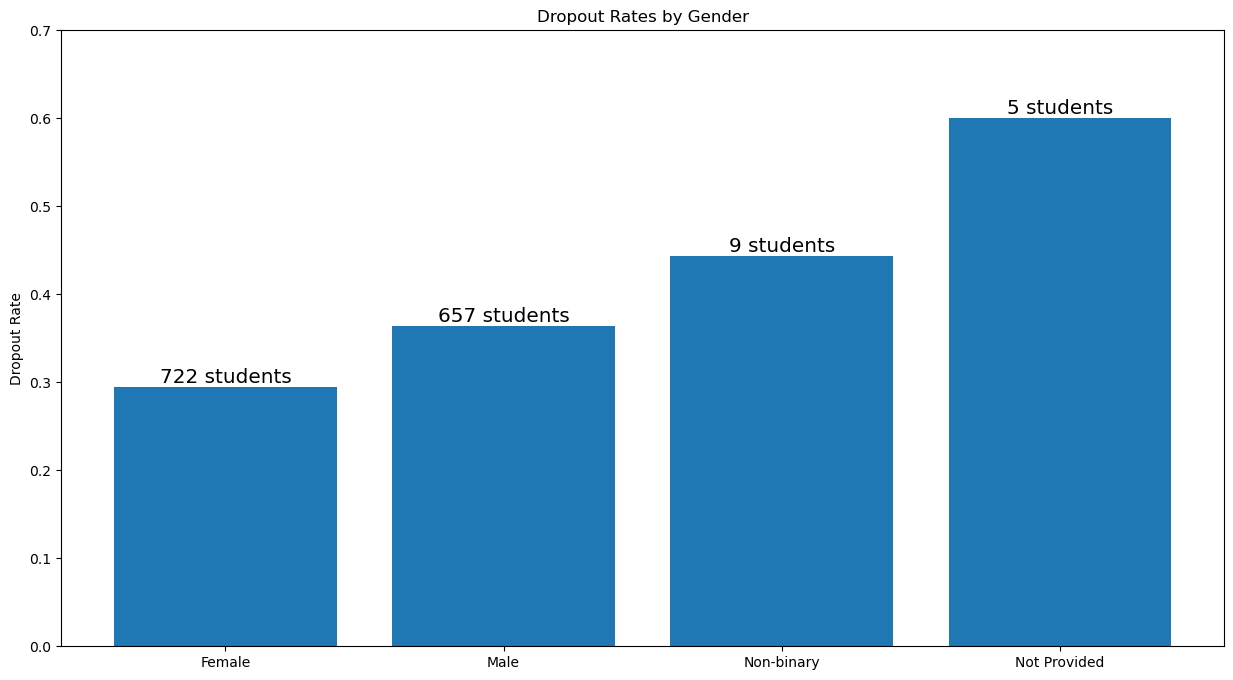

In [67]:
plt.figure(figsize=(15,8))
plt.bar(dfGender['Gender'],dfGender['Drop-out Rate']);
plt.ylabel('Dropout Rate')
plt.ylim([0, 0.7])
plt.title('Dropout Rates by Gender')

countList = dfGender['Count'].astype('str').tolist()
labels = [student + ' students' for student in countList]
 
for i, label in enumerate(labels):
    plt.text(i, dfGender['Drop-out Rate'][i], label, ha='center', va='bottom', fontsize = 'x-large')

plt.show();

#### Summary of Findings for <u>Gender</u>
- Female students are less likely to drop out of college.

<u>Action</u>:

- Replace 'Gender' with the numeric 'sex' variable to be used in development.

#### '% of scholarships not accepted'

In [68]:
df['% of scholarships not accepted'].value_counts(dropna = False)

NaN      413
0%       299
-50%     189
-100%    114
-33%      24
        ... 
-31%       1
-15%       1
-86%       1
-10%       1
-6%        1
Name: % of scholarships not accepted, Length: 82, dtype: int64

In [69]:
#Create a new column with numeric values for '% of scholarships not accepted' by stripping "%"
df['percScholarshipNotAccepted'] = pd.to_numeric(df['% of scholarships not accepted'].str.strip("%"))

In [70]:
#Create a new variable for percentage of scholarships accepted, all null values were set to a special value of -1
df['percScholarshipAccepted'] =  df['percScholarshipNotAccepted'].map(lambda x: -1 if pd.isnull(x) else 100 + x)
df['percScholarshipAccepted'].head()

0    17.0
1     0.0
2    50.0
3    66.0
4    83.0
Name: percScholarshipAccepted, dtype: float64

In [71]:
#Create a binned variable for the percentage of scholarship accepted
percBinning = [-1,0,10,20,30,40,50,60,70,80,90,100,float("inf")]
df["percScholarshipAcceptedBinned"] = pd.cut(x = df["percScholarshipAccepted"], right = False, bins = percBinning)

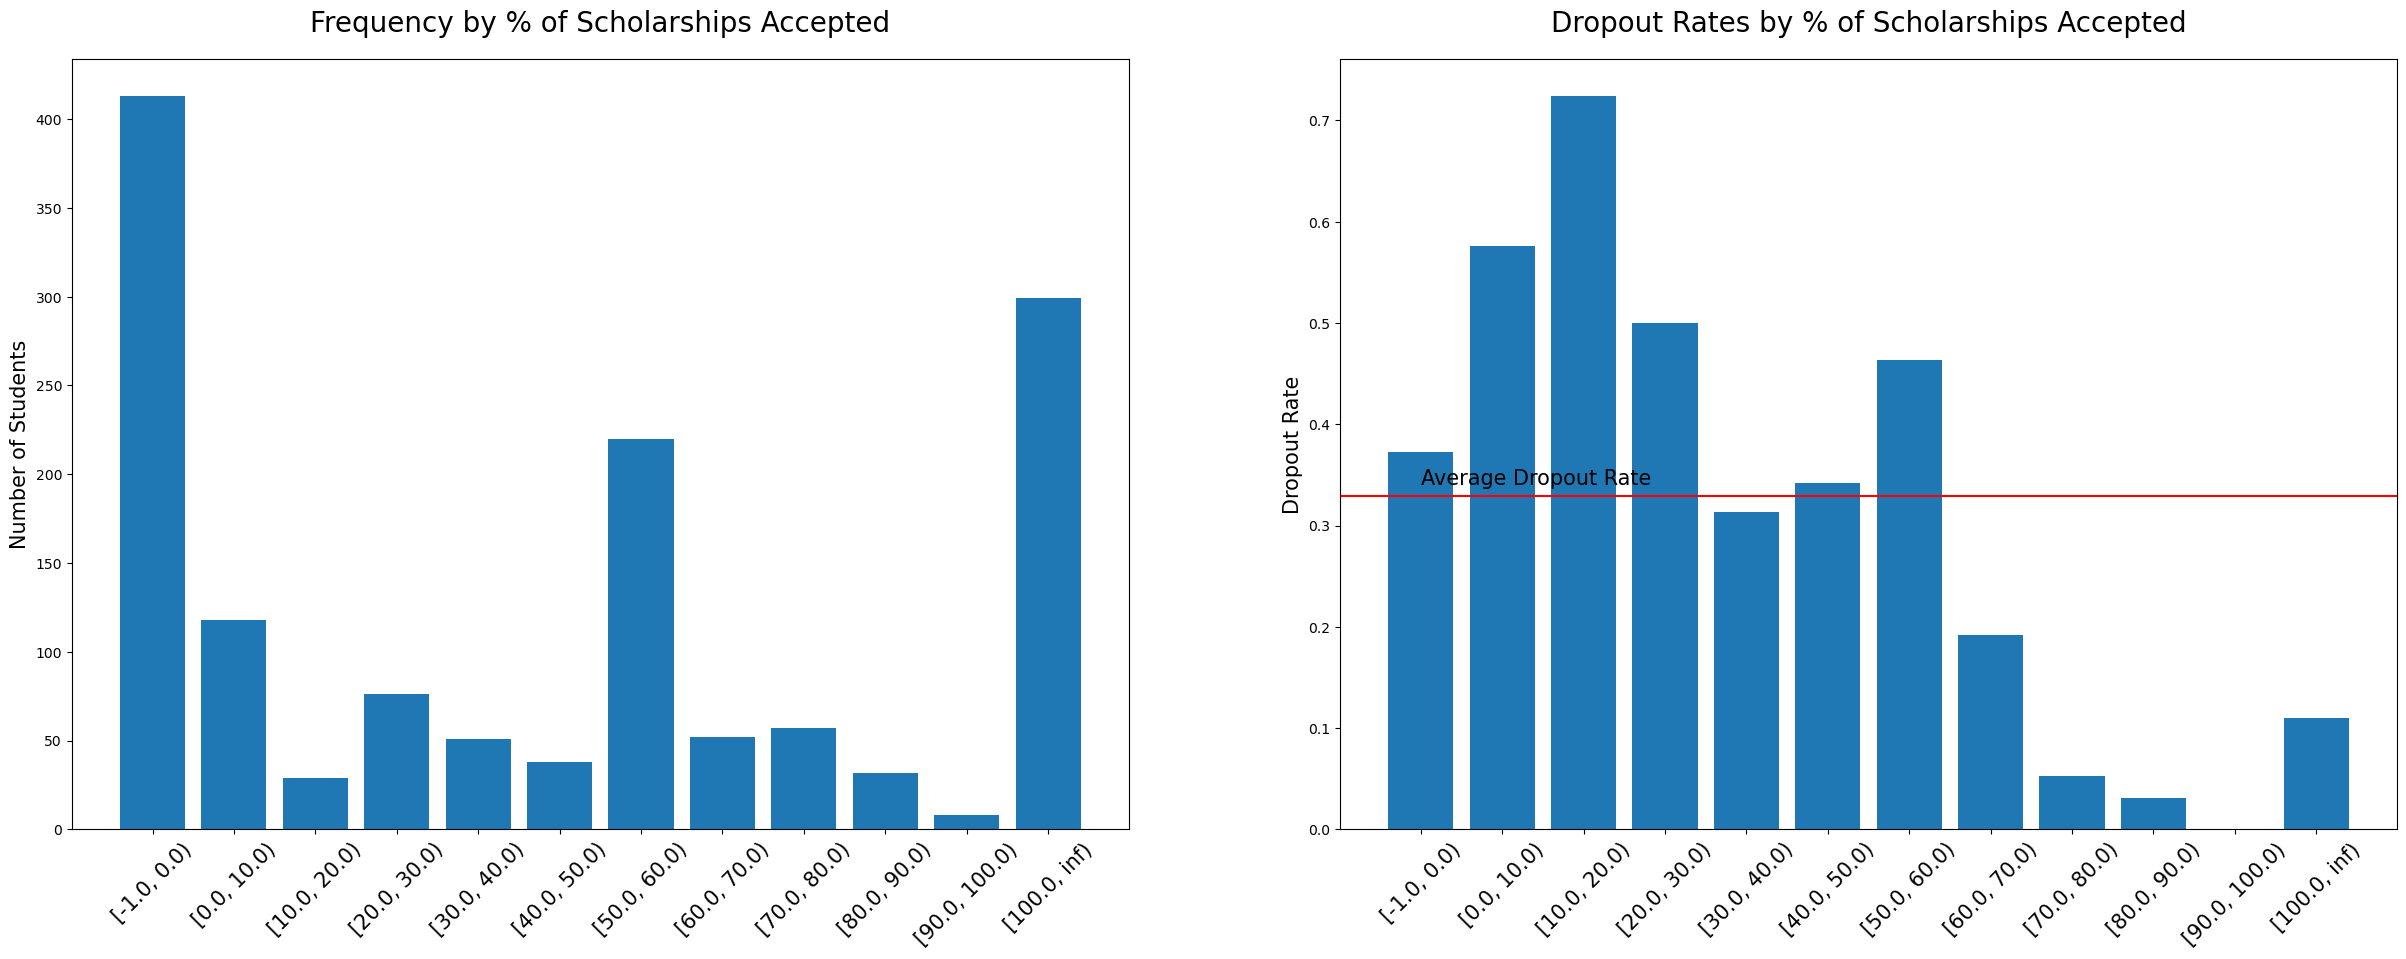

In [72]:
percScholarshipCount = pd.DataFrame(df.groupby("percScholarshipAcceptedBinned")['persistIndicator'].agg('count')).reset_index()
percScholarshipAvg = pd.DataFrame(df.groupby("percScholarshipAcceptedBinned")['persistIndicator'].agg('mean')).reset_index()

percScholarshipCount['percScholarshipAcceptedBinned'] = percScholarshipCount['percScholarshipAcceptedBinned'].astype(str)
percScholarshipAvg['percScholarshipAcceptedBinned'] = percScholarshipAvg['percScholarshipAcceptedBinned'].astype(str)

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,percScholarshipCount['percScholarshipAcceptedBinned'], percScholarshipCount.persistIndicator,"Frequency by % of Scholarships Accepted")
histCatVariablesNonPersistenceRate(1,percScholarshipAvg['percScholarshipAcceptedBinned'],percScholarshipAvg.persistIndicator,"Dropout Rates by % of Scholarships Accepted")

In [73]:
#Decided to assign missing values (-1) to 50% so that the drop-out rate rank orders with this group included
df['percScholarshipAcceptedTemp'] =  df['percScholarshipAccepted'] #This new variable will be used to calculate the correlation of this variable with the '# of scholarships since 2015'
df['percScholarshipAccepted'] =  df['percScholarshipAccepted'].map(lambda x: 50 if x == -1 else x)

In [74]:
percBinning = [0,10,20,30,40,50,60,70,80,90,100,float("inf")]
df["percScholarshipAcceptedBinned"] = pd.cut(x = df["percScholarshipAccepted"], right = False, bins = percBinning)

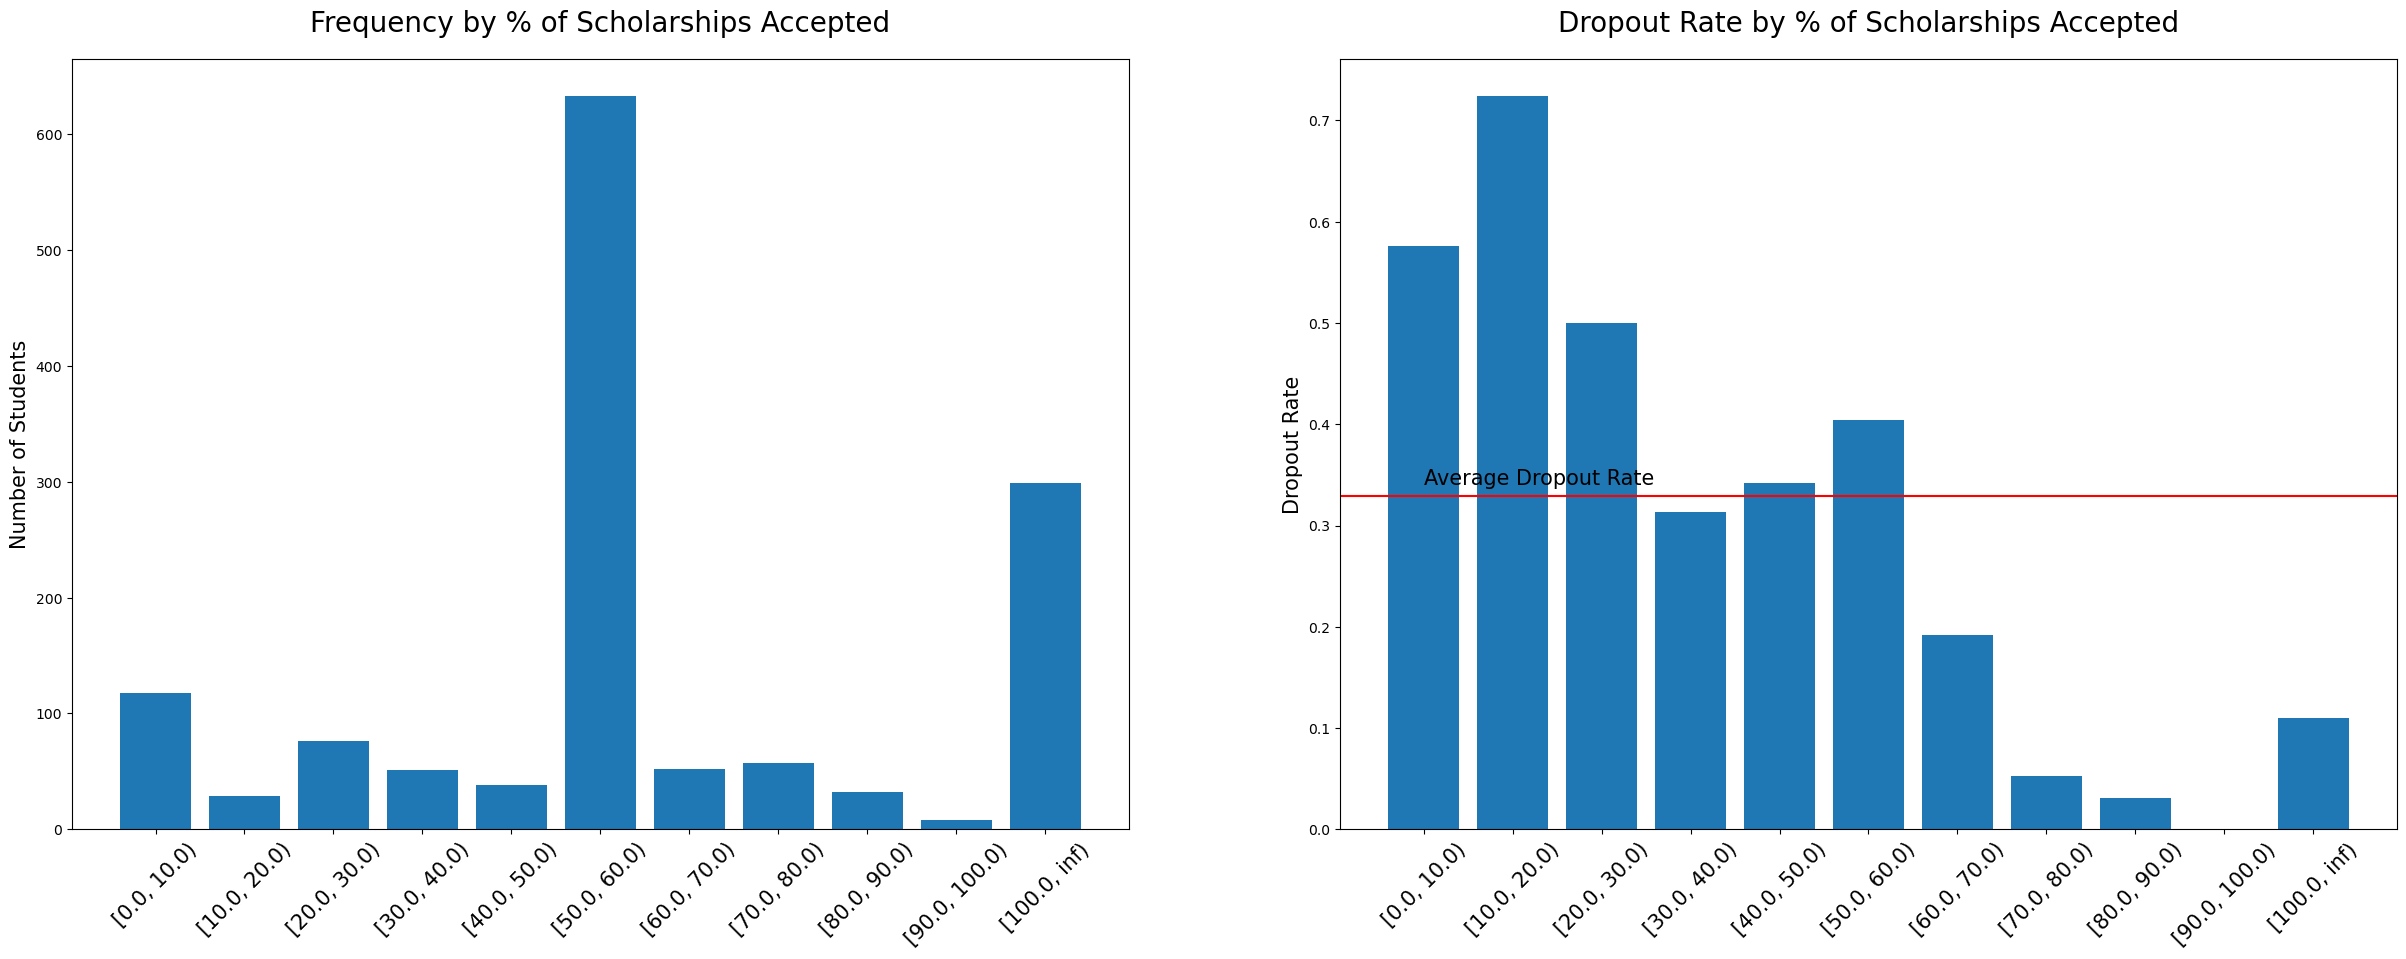

In [75]:
#Scholarship
percScholarshipCount = pd.DataFrame(df.groupby("percScholarshipAcceptedBinned")['persistIndicator'].agg('count')).reset_index()
percScholarshipAvg = pd.DataFrame(df.groupby("percScholarshipAcceptedBinned")['persistIndicator'].agg('mean')).reset_index()

percScholarshipCount['percScholarshipAcceptedBinned'] = percScholarshipCount['percScholarshipAcceptedBinned'].astype(str)
percScholarshipAvg['percScholarshipAcceptedBinned'] = percScholarshipAvg['percScholarshipAcceptedBinned'].astype(str)

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,percScholarshipCount['percScholarshipAcceptedBinned'], percScholarshipCount.persistIndicator,"Frequency by % of Scholarships Accepted")
histCatVariablesNonPersistenceRate(1,percScholarshipAvg['percScholarshipAcceptedBinned'],percScholarshipAvg.persistIndicator,"Dropout Rate by % of Scholarships Accepted")

#### Summary of Findings for <u>% of scholarships not accepted</u>
- Students who accepted a larger percentage of their scholarship are more likely to persist.
- After discussions with 10,000 Degrees, it was concluded that the variable indicating scholarship acceptance could potentially be a target leaker, as some of the data is collected during the second year of the college.

<u>Action</u>:

- Drop this variable.

####  'Race/Ethnicity'

In [76]:
df['Race Ethnicity'].value_counts(dropna = False)

Hispanic/Latino/a/x                                     857
Asian                                                   184
White                                                   103
Not Provided                                             92
Black/African American                                   82
Multiracial/Multiethnic                                  50
Not listed /prefer to self-describe                      16
American Indian/Indigenous American or Alaska Native      5
Pacific Islander                                          4
Name: Race Ethnicity, dtype: int64

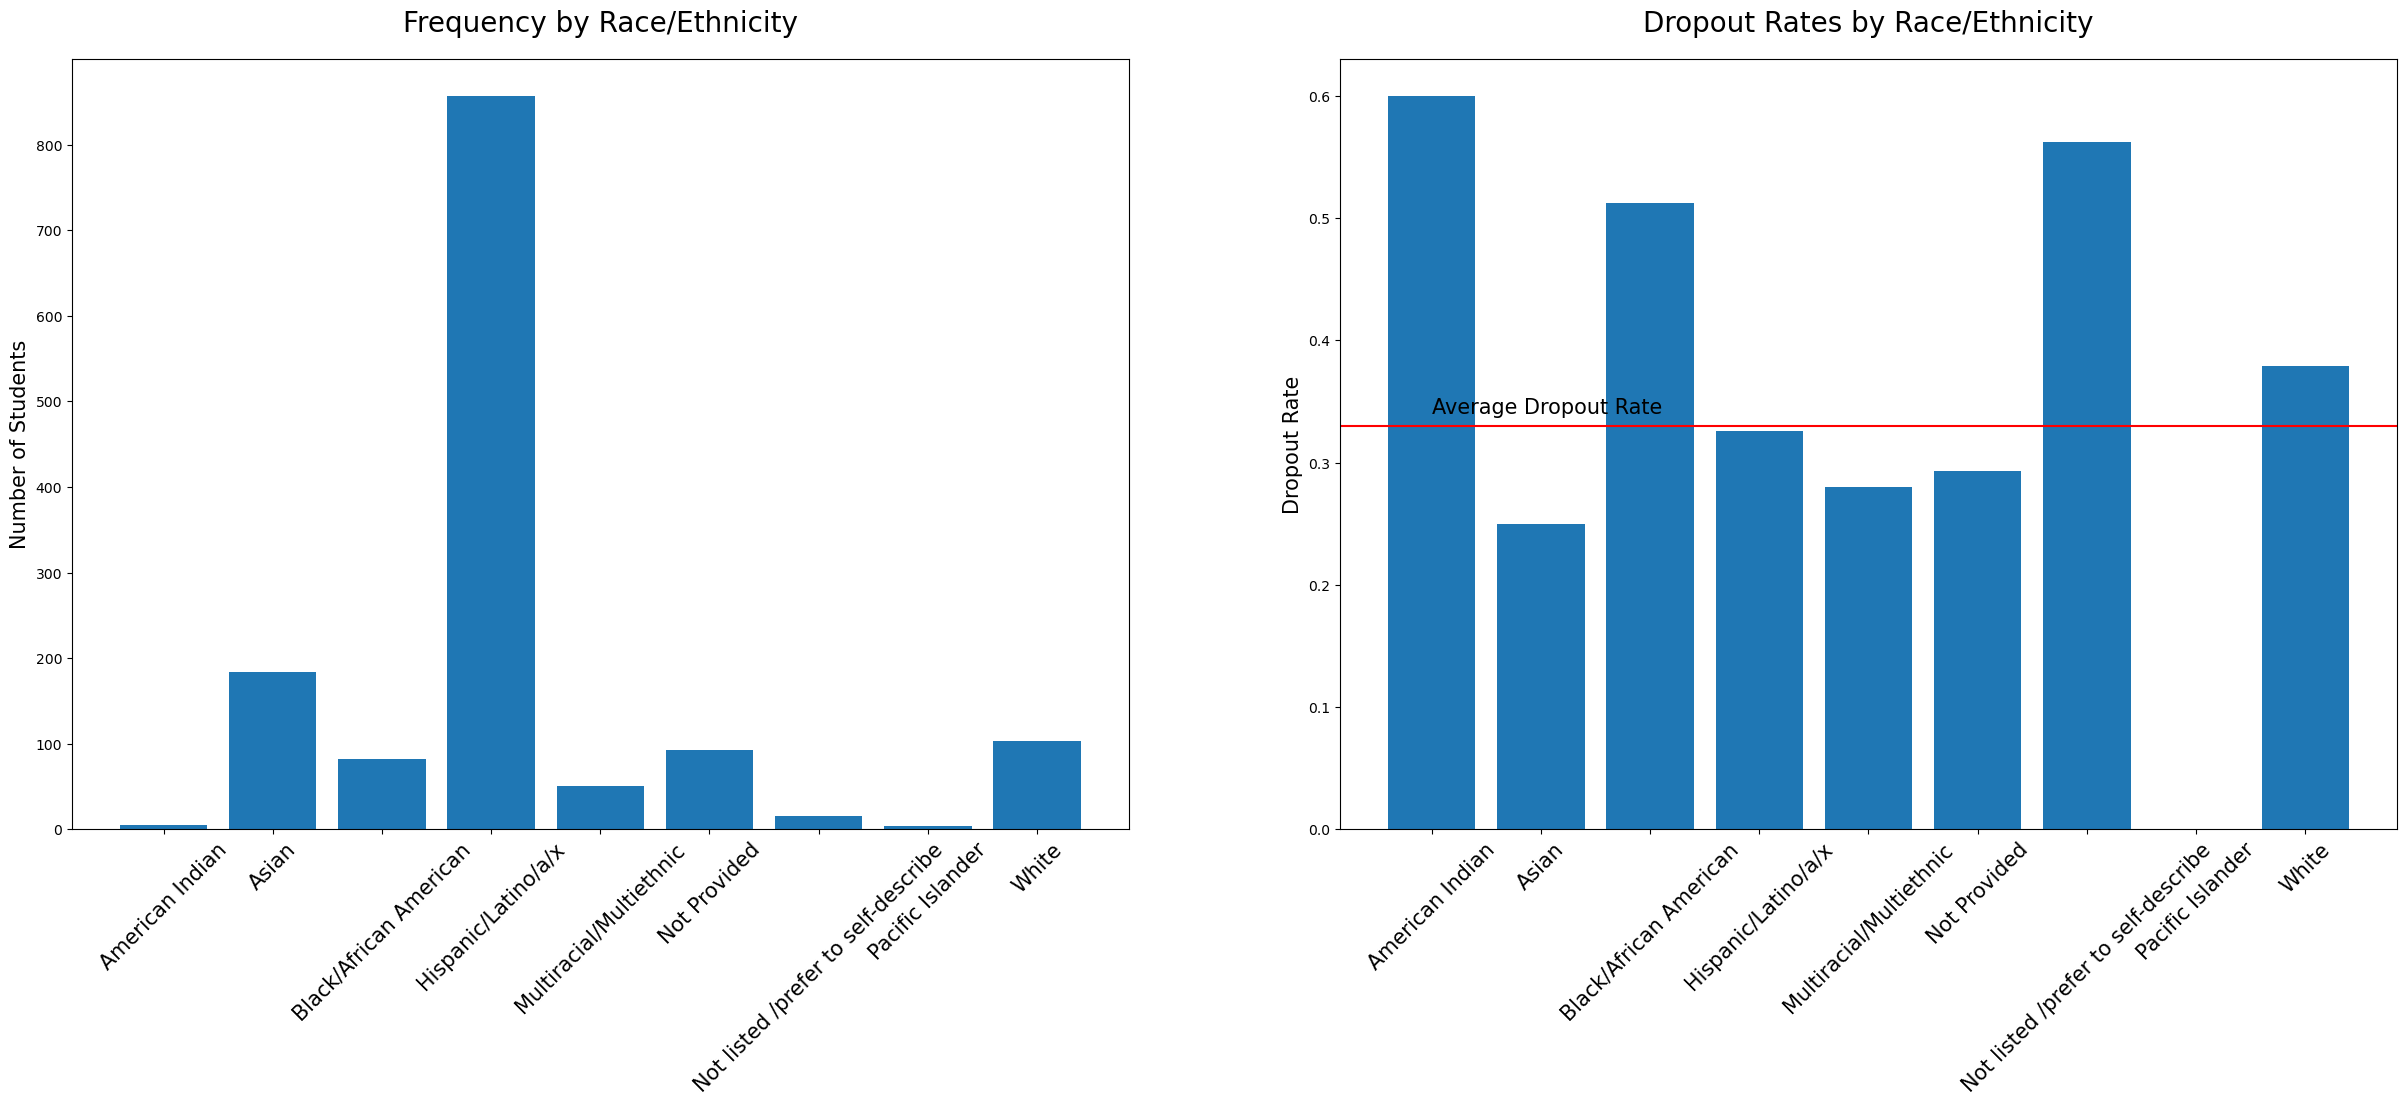

In [77]:
dfRaceCount = pd.DataFrame(df.groupby("Race Ethnicity")['persistIndicator'].agg('count')).reset_index()
dfRaceAvg = pd.DataFrame(df.groupby("Race Ethnicity")['persistIndicator'].agg('mean')).reset_index()

dfRaceCount['Race Ethnicity'] = dfRaceCount['Race Ethnicity'].map(lambda x: 'American Indian' if "American Indian/Indigenous American or Alaska" in x else x)
dfRaceAvg['Race Ethnicity'] = dfRaceAvg['Race Ethnicity'].map(lambda x: 'American Indian' if "American Indian/Indigenous American or Alaska" in x else x)

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfRaceCount['Race Ethnicity'],dfRaceCount.persistIndicator,"Frequency by Race/Ethnicity")
histCatVariablesNonPersistenceRate(1,dfRaceAvg['Race Ethnicity'],dfRaceAvg.persistIndicator,"Dropout Rates by Race/Ethnicity")


In [78]:
#Group race/ethnicity for Hispanic, Asian, White, Black, Other and Not Provided
raceDict = {'Hispanic/Latino/a/x':'Hispanic',
            'Asian':'Asian',
            'White':'White',
            'Black/African American':'Black',
            'Not Provided': 'Not Provided',
            'Multiracial/Multiethnic':'Other',
            'Not listed /prefer to self-describe':'Not Provided',
            'American Indian/Indigenous American or Alaska Native':'Other',
            'Pacific Islander':'Other'}

df['race'] =df['Race Ethnicity'].map(raceDict)
df['race'].value_counts()

Hispanic        857
Asian           184
Not Provided    108
White           103
Black            82
Other            59
Name: race, dtype: int64

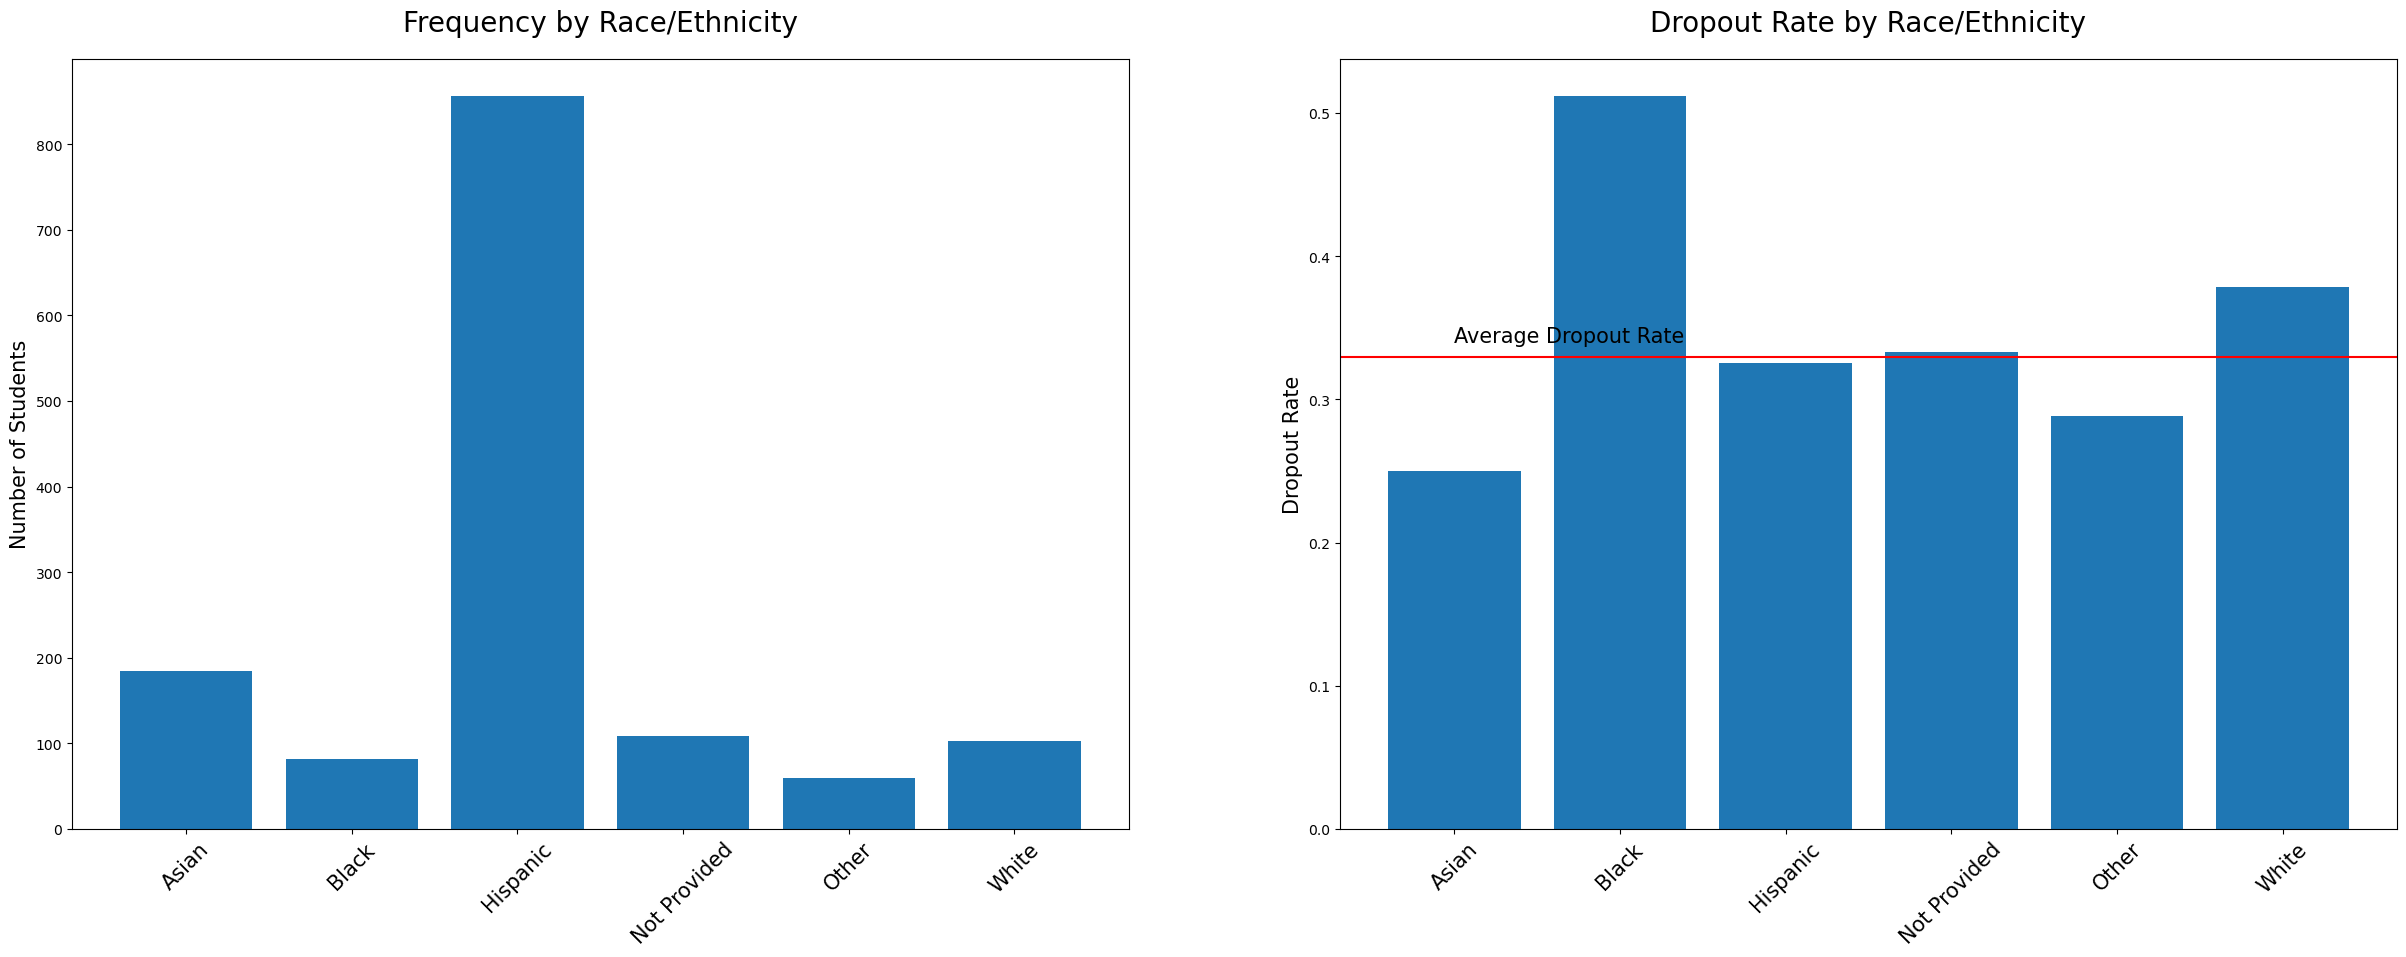

In [79]:
dfRaceCount = pd.DataFrame(df.groupby("race")['persistIndicator'].agg('count')).reset_index()
dfRaceAvg = pd.DataFrame(df.groupby("race")['persistIndicator'].agg('mean')).reset_index()

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfRaceCount['race'],dfRaceCount.persistIndicator,"Frequency by Race/Ethnicity")
histCatVariablesNonPersistenceRate(1,dfRaceAvg['race'],dfRaceAvg.persistIndicator,"Dropout Rate by Race/Ethnicity")

In [80]:
#Map race to numeric values based on their drop-out rate
raceDict = {'Black':1,
            'White':2,
            'Not Provided':3,
            'Hispanic':4,
            'Other':5,
            'Asian':6}

df['race'] = df['race'].map(raceDict)
df['race'].value_counts()

4    857
6    184
3    108
2    103
1     82
5     59
Name: race, dtype: int64

#### Summary of Findings for <u>Race Ethnicity</u>
- Asian students have a lower likelihood of dropping out, whereas students with African American background are more likely to drop out.

<u>Action</u>:

- Drop 'Race Ethnicity' and replace it with the numeric 'race' to be used in development.

####  'Transfer status'

- No -> Still in 2 year
- Transfer -> Transferred to a 4-year college

In [81]:
dfTransferStatus = df.groupby('Transfer status')['persistIndicator'].agg(['count','mean']).rename(columns = {"count": "Count","mean":"Dropout Rate"}).reset_index().round(3)
dfTransferStatus

,Transfer status,Count,Dropout Rate
0,No,1286,0.351
1,Transfer,107,0.065


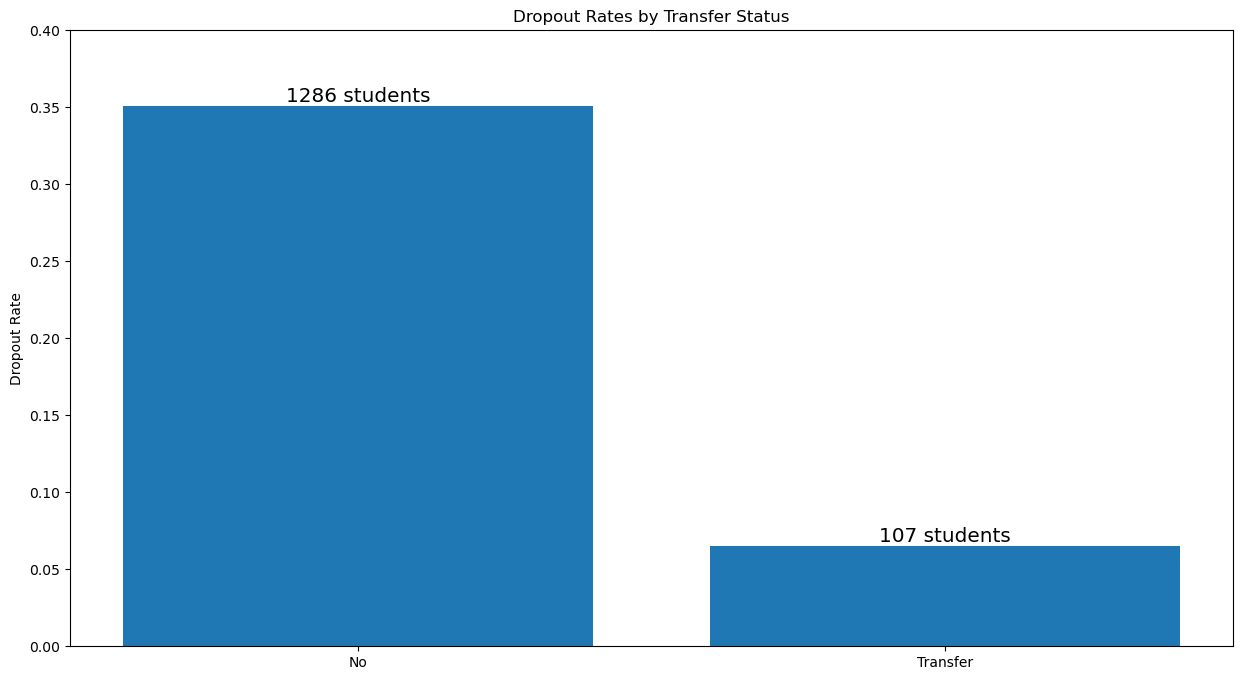

In [82]:
plt.figure(figsize=(15,8))
plt.bar(dfTransferStatus['Transfer status'],dfTransferStatus['Dropout Rate']);
plt.ylabel('Dropout Rate')
plt.ylim([0, 0.4])
plt.title('Dropout Rates by Transfer Status')

countList = dfTransferStatus['Count'].astype('str').tolist()
labels = [student + ' students' for student in countList]

for i, label in enumerate(labels):
    plt.text(i, dfTransferStatus['Dropout Rate'][i], label, ha='center', va='bottom', fontsize = 'x-large')

plt.show();

#### Summary of Findings for <u>Transfer status</u>
- Transfer students are less likely to drop out but students take action to transfer to 4-year colleges during their second year. Therefore, this variable is a target leaker and should not be used for model development.

<u>Action</u>:

- Drop 'Transfer Status'

####  'HS Region'

In [83]:
df['HS Region'].value_counts(dropna = False)

Marin           536
Sonoma          355
SF Region       248
Napa County      89
Contra Costa     71
Santa Clara      53
Other            25
Unknown           8
San Mateo         7
Alameda           1
Name: HS Region, dtype: int64

In [84]:
#Combine Other, Unknown, San Mateo and Alameda in one group Other due to low counts
df['HS Region'] = df['HS Region'].replace(['Unknown','San Mateo','Alameda'],'Other')
#Clean up the name for Napa
df['HS Region'] = df['HS Region'].replace('Napa County','Napa')
df['HS Region'].value_counts()

Marin           536
Sonoma          355
SF Region       248
Napa             89
Contra Costa     71
Santa Clara      53
Other            41
Name: HS Region, dtype: int64

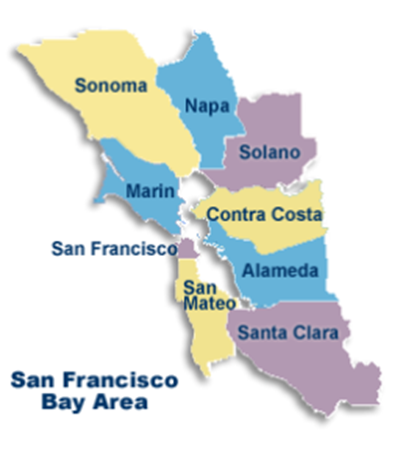

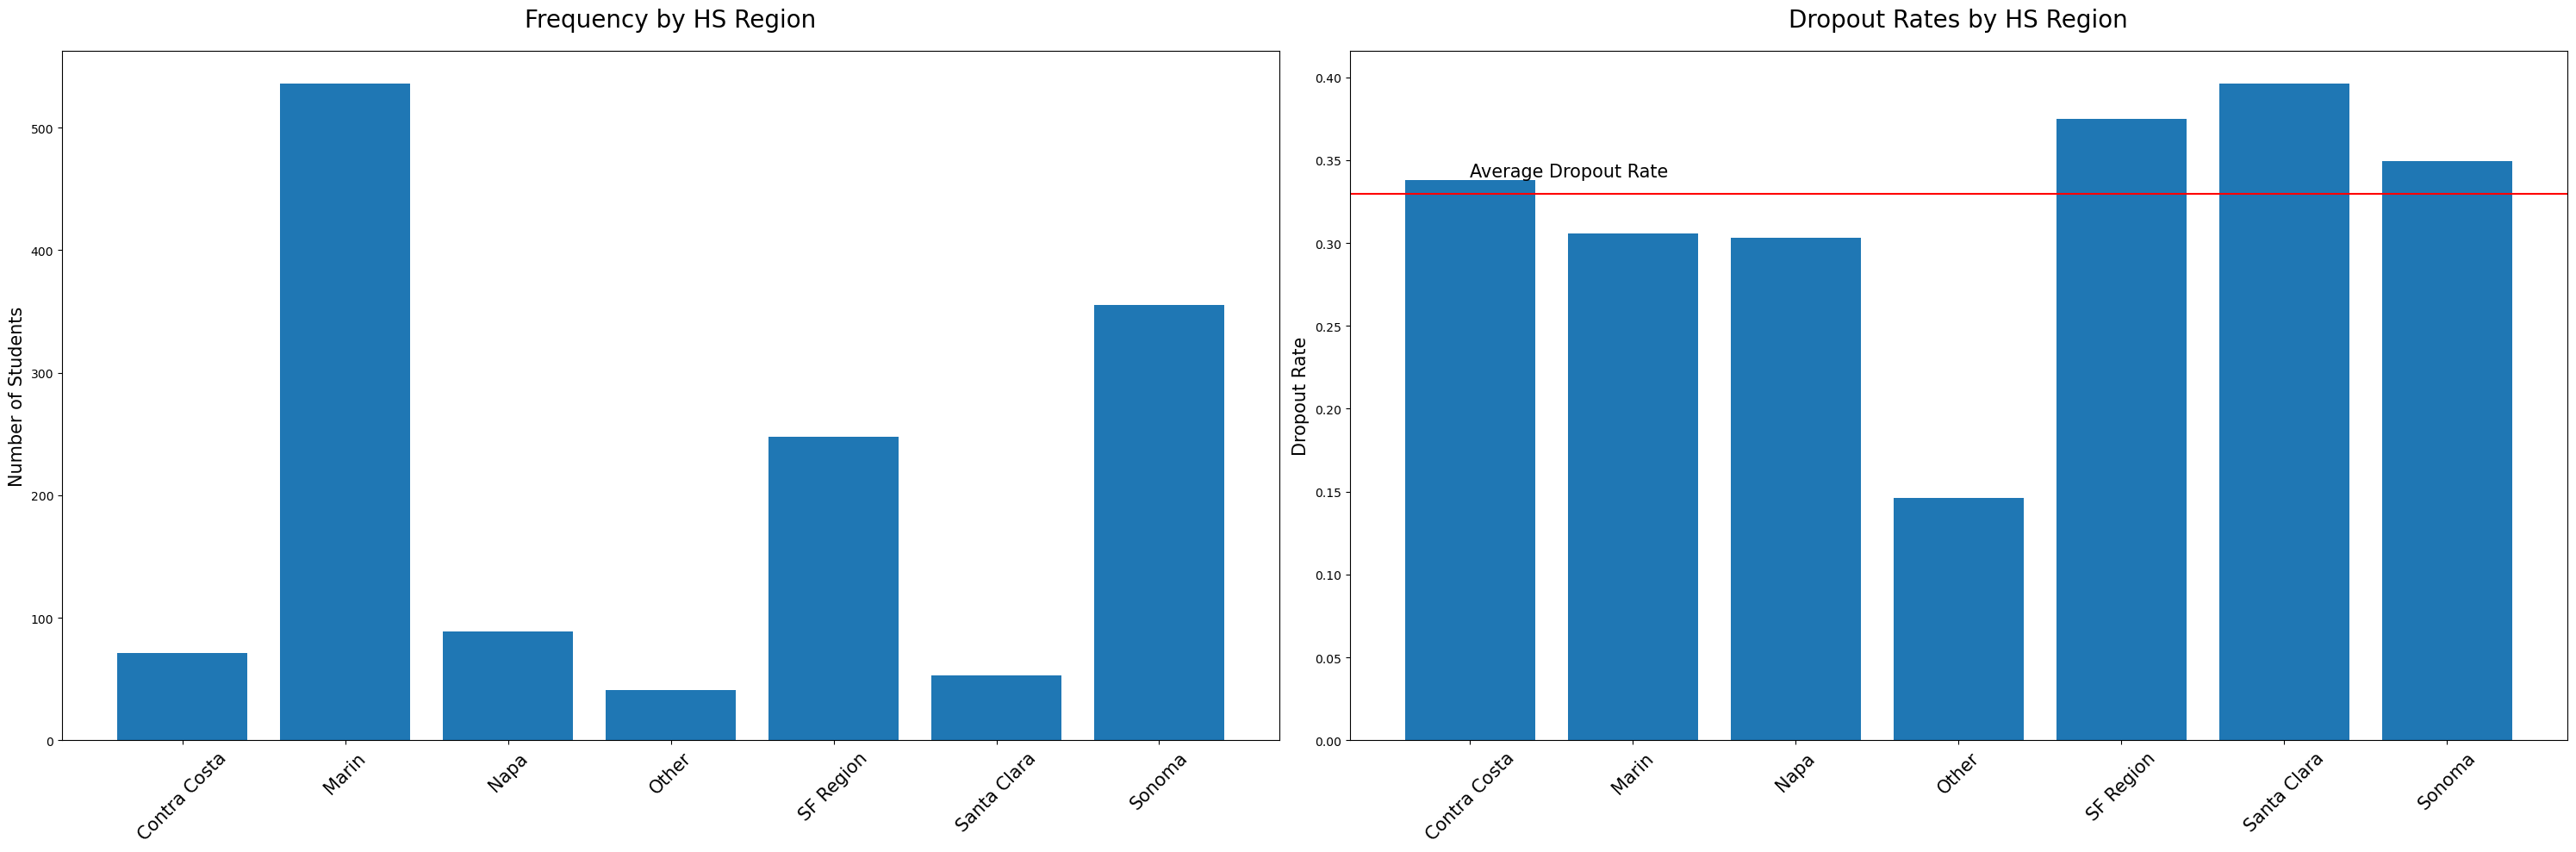

In [85]:
dfHSRegionCount = pd.DataFrame(df.groupby("HS Region")['persistIndicator'].agg('count')).reset_index()
dfHSRegionAvg = pd.DataFrame(df.groupby("HS Region")['persistIndicator'].agg('mean')).reset_index()

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,dfHSRegionCount['HS Region'],dfHSRegionCount.persistIndicator,"Frequency by HS Region")
histCatVariablesNonPersistenceRate(1,dfHSRegionAvg['HS Region'],dfHSRegionAvg.persistIndicator,"Dropout Rates by HS Region")

fig.tight_layout();

In [86]:
dfHSRegionAvg.sort_values(by = 'persistIndicator').rename(columns = {'persistIndicator':'Dropout Rate'}).round(3)

,HS Region,Dropout Rate
3,Other,0.146
2,Napa,0.303
1,Marin,0.306
0,Contra Costa,0.338
6,Sonoma,0.349
4,SF Region,0.375
5,Santa Clara,0.396


In [87]:
#Map region to numeric values based on dropout rate
hsRegionDict = {'Other':1,
                'Napa':2,
                'Marin':3,
                'Contra Costa':4,
                'Sonoma':5,
                'SF Region':6,
                'Santa Clara':7}

df['hsRegion'] =df['HS Region'].map(hsRegionDict)

#### Summary of Findings for <u>HS Region</u>
- Students living in Marin and Napa are more likely to persist.

<u>Action</u>:

- Drop HS Region and use the numeric hsRegion variable.

####  '# of scholarships since 2015'

In [88]:
df['# of scholarships since 2015'].value_counts(dropna = False)

1.0    471
NaN    413
2.0    250
3.0    131
4.0     63
5.0     41
6.0     15
7.0      8
8.0      1
Name: # of scholarships since 2015, dtype: int64

In [89]:
#Replace missing with -1
df['numScholarships'] = df["# of scholarships since 2015"].fillna(-1)
df['numScholarshipsString'] = df['numScholarships'].astype(str)
df['numScholarshipsString'].value_counts(dropna = False)
df['numScholarships'].value_counts(dropna = False)

1.0     471
-1.0    413
2.0     250
3.0     131
4.0      63
5.0      41
6.0      15
7.0       8
8.0       1
Name: numScholarshipsString, dtype: int64

 1.0    471
-1.0    413
 2.0    250
 3.0    131
 4.0     63
 5.0     41
 6.0     15
 7.0      8
 8.0      1
Name: numScholarships, dtype: int64

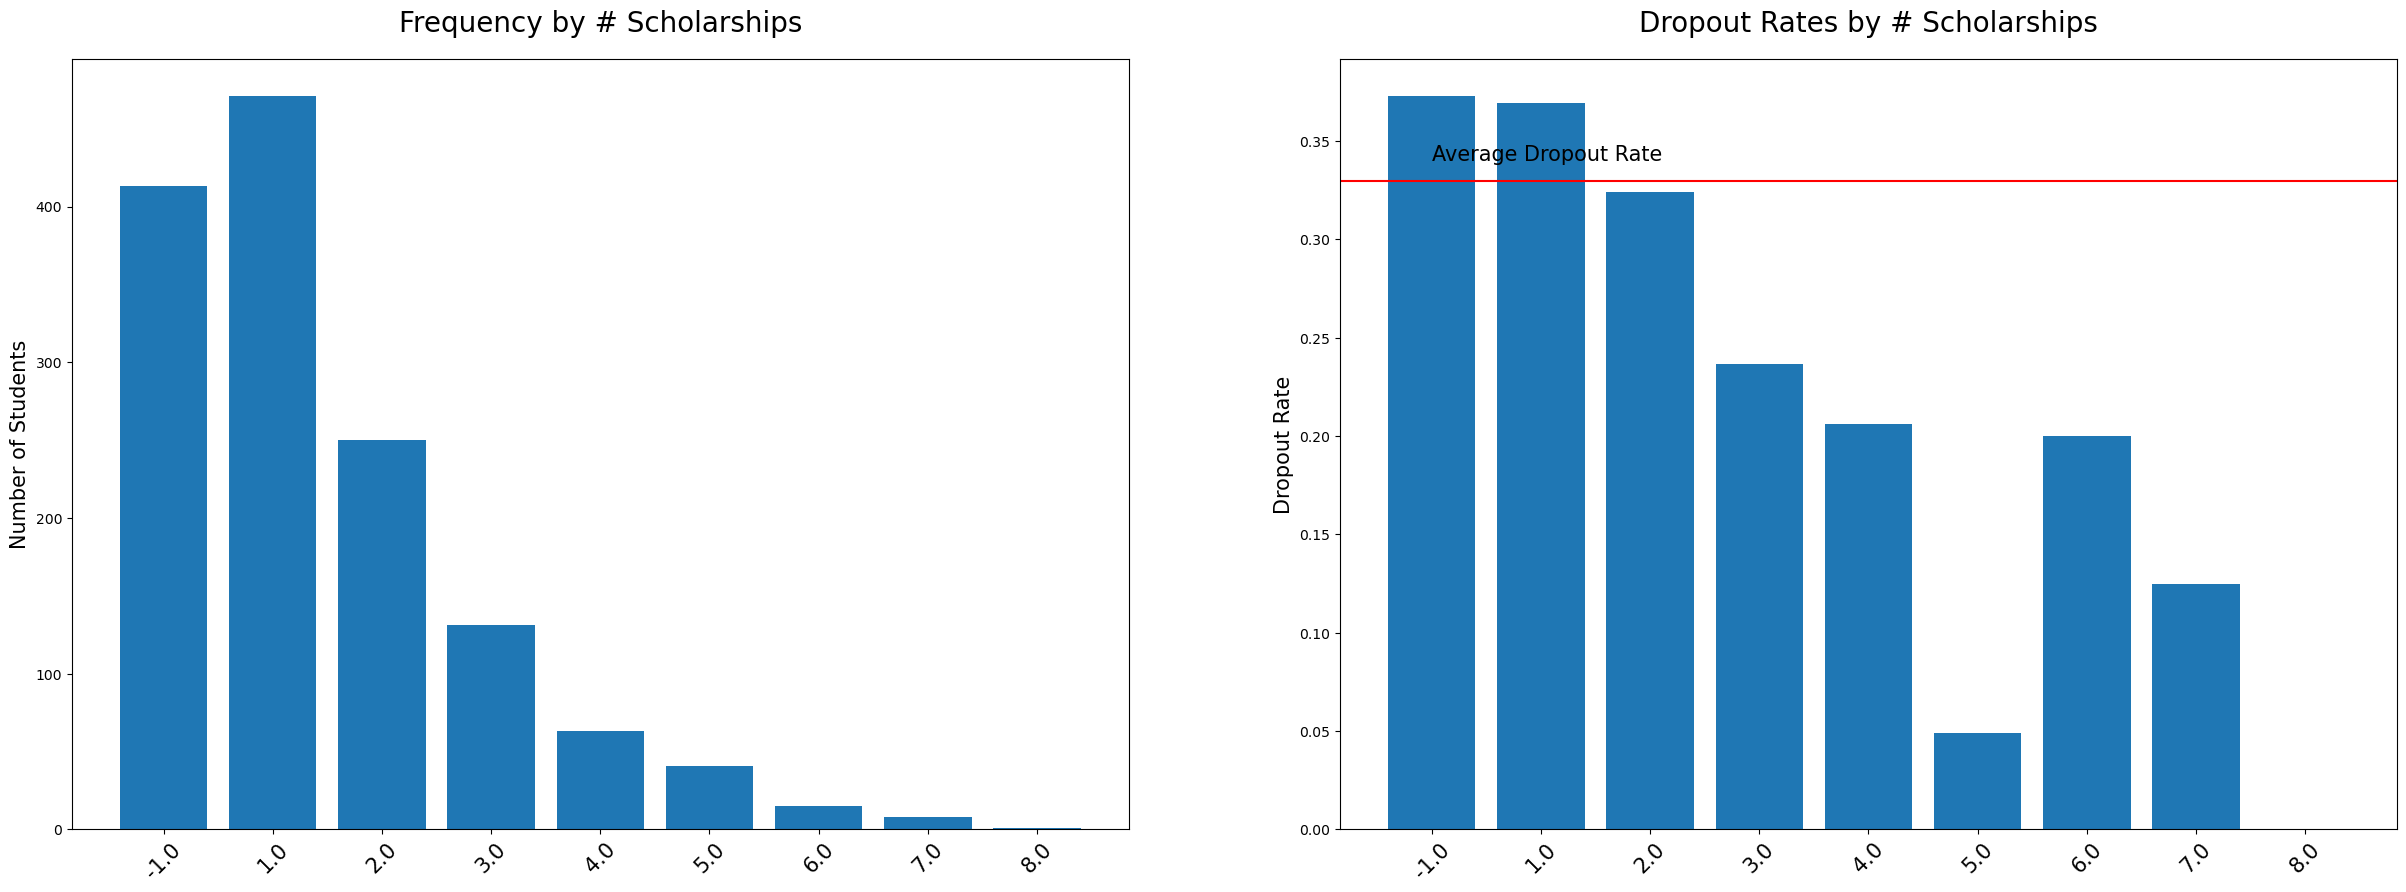

In [90]:
numScholarshipsCount = pd.DataFrame(df.groupby("numScholarshipsString")['persistIndicator'].agg('count')).reset_index()
numScholarshipsAvg = pd.DataFrame(df.groupby("numScholarshipsString")['persistIndicator'].agg('mean')).reset_index()

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,numScholarshipsCount['numScholarshipsString'],numScholarshipsCount.persistIndicator,"Frequency by # Scholarships")
histCatVariablesNonPersistenceRate(1,numScholarshipsAvg['numScholarshipsString'],numScholarshipsAvg.persistIndicator,"Dropout Rates by # Scholarships")

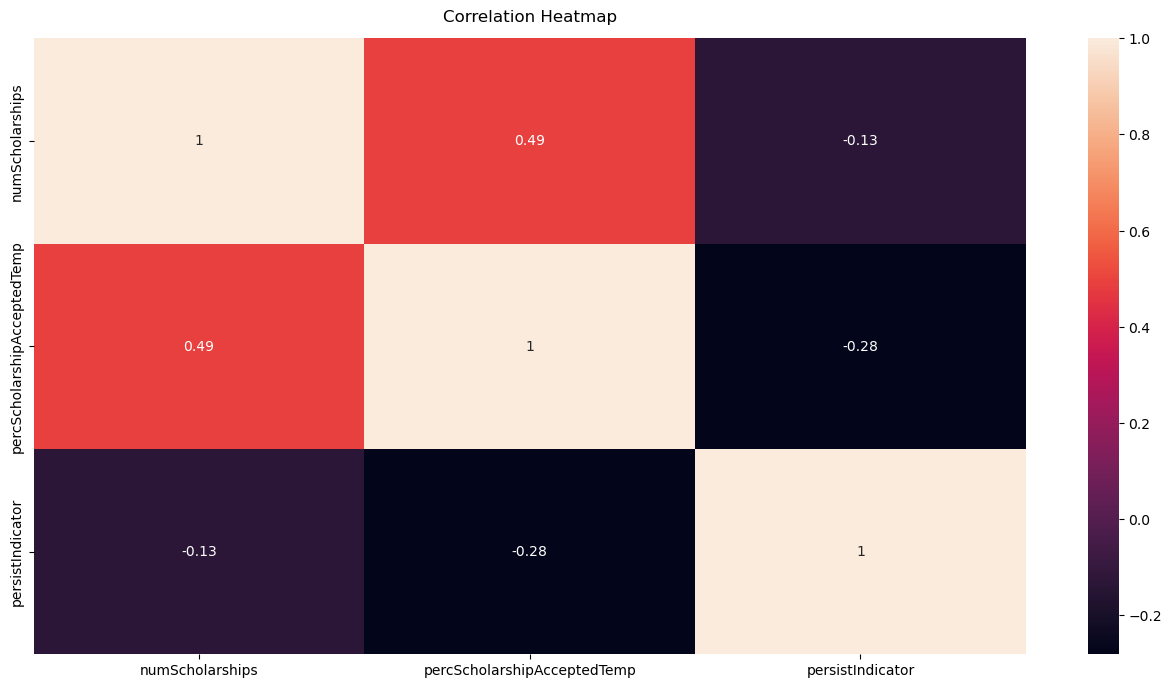

In [91]:
#Review the correlation between 'numScholarships' and 'percScholarshipAccepted'
plt.figure(figsize=(16,8)) 
heatmap = sns.heatmap(df[['numScholarships','percScholarshipAcceptedTemp','persistIndicator']].corr(), annot = True);
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### Summary of Findings for <u># of scholarships since 2015</u>
- A significant percentage of the students do not have this variable populated. Since we are not sure if this means that they didn't get any scholarships, we decided to identify them as a special value with -1.
- Number of scholarships is highly correlated with percentage of scholarship accepted but its correlation with the target is weaker.
- Like the "percentage of scholarship accepted" variable, this variable is also a source of data leakage since some of the information is gathered in the second year of college.

<u>Action</u>:

- Drop '# of scholarships since 2015".

#### 'First College Enrollment Date' and 'Months Until FCE' (FCE = First College Enrollment)

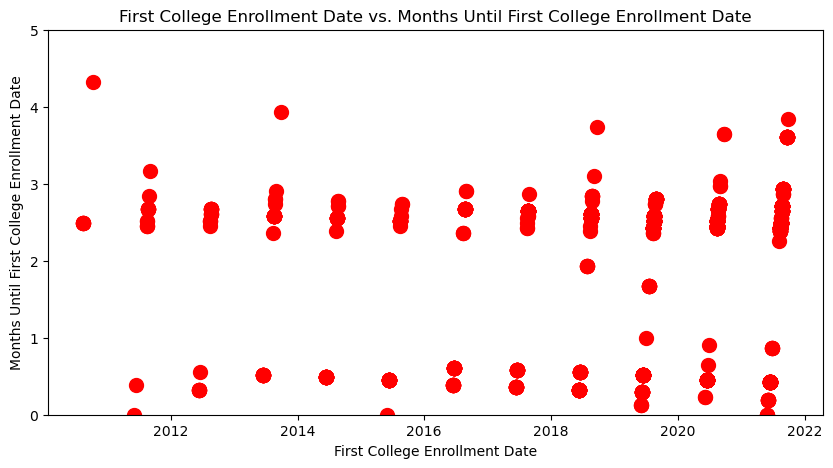

In [92]:
fig, ax = plt.subplots(1, figsize = (10, 5))
plt.title("First College Enrollment Date vs. Months Until First College Enrollment Date")
plt.scatter(df['First College Enrollment Date'], df['Months Until FCE'], s =100, c = 'red')
plt.xlabel("First College Enrollment Date")
plt.ylabel("Months Until First College Enrollment Date")
plt.ylim(0,5);

'Months Until FCE' is 0-5 months for each year since the schools generally close in May-June.

Let's first analyze 'Months Until FCE'.

In [93]:
fceBinning = [0,1,2,3,4,5]
df["fCEBinned"] = pd.cut(x = df["Months Until FCE"], right = False, bins = fceBinning)

df["fCEBinned"].value_counts(dropna = False).sort_index()

[0, 1)    441
[1, 2)     14
[2, 3)    908
[3, 4)     29
[4, 5)      1
Name: fCEBinned, dtype: int64

The counts for 1, 3 and 4 months are very low. Decided to apply coarser binning.

In [94]:
fceBinning = [0,1,5]
df["fCEBinned"] = pd.cut(x = df["Months Until FCE"], right = False, bins = fceBinning)

df["fCEBinned"].value_counts(dropna = False).sort_index()

[0, 1)    441
[1, 5)    952
Name: fCEBinned, dtype: int64

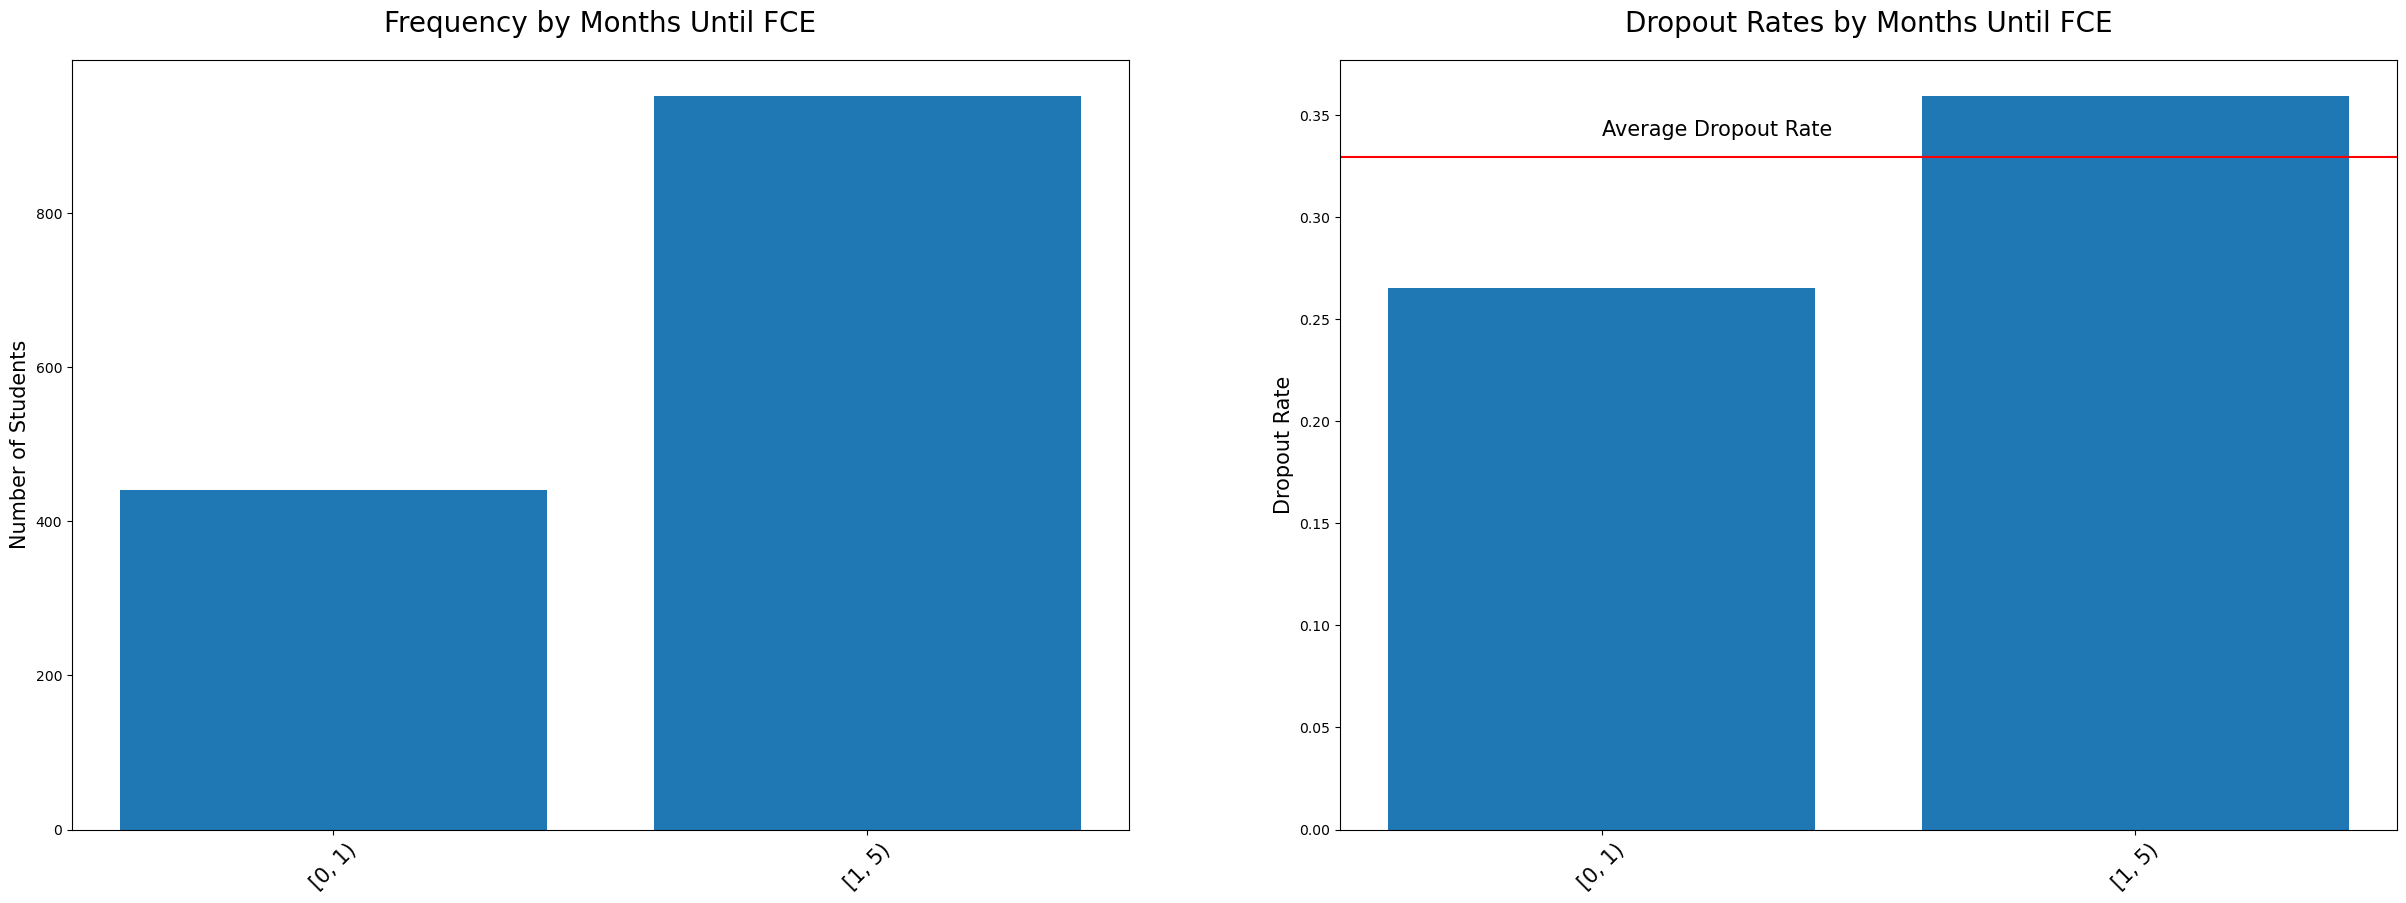

In [95]:
fCECount = pd.DataFrame(df.groupby("fCEBinned")['persistIndicator'].agg('count')).reset_index()
fCEAvg = pd.DataFrame(df.groupby("fCEBinned")['persistIndicator'].agg('mean')).reset_index()

fCECount['fCEBinned'] = fCECount['fCEBinned'].astype(str)
fCEAvg['fCEBinned'] = fCEAvg['fCEBinned'].astype(str)

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,fCECount['fCEBinned'],fCECount.persistIndicator,"Frequency by Months Until FCE")
histCatVariablesNonPersistenceRate(1,fCEAvg['fCEBinned'],fCEAvg.persistIndicator,"Dropout Rates by Months Until FCE")

Let's now analyze First College Enrollment Date

In [96]:
#Convert YYYY-MM-DD into YYYY
df['firstCollegeEnrollmentYear'] = df['First College Enrollment Date'].dt.year

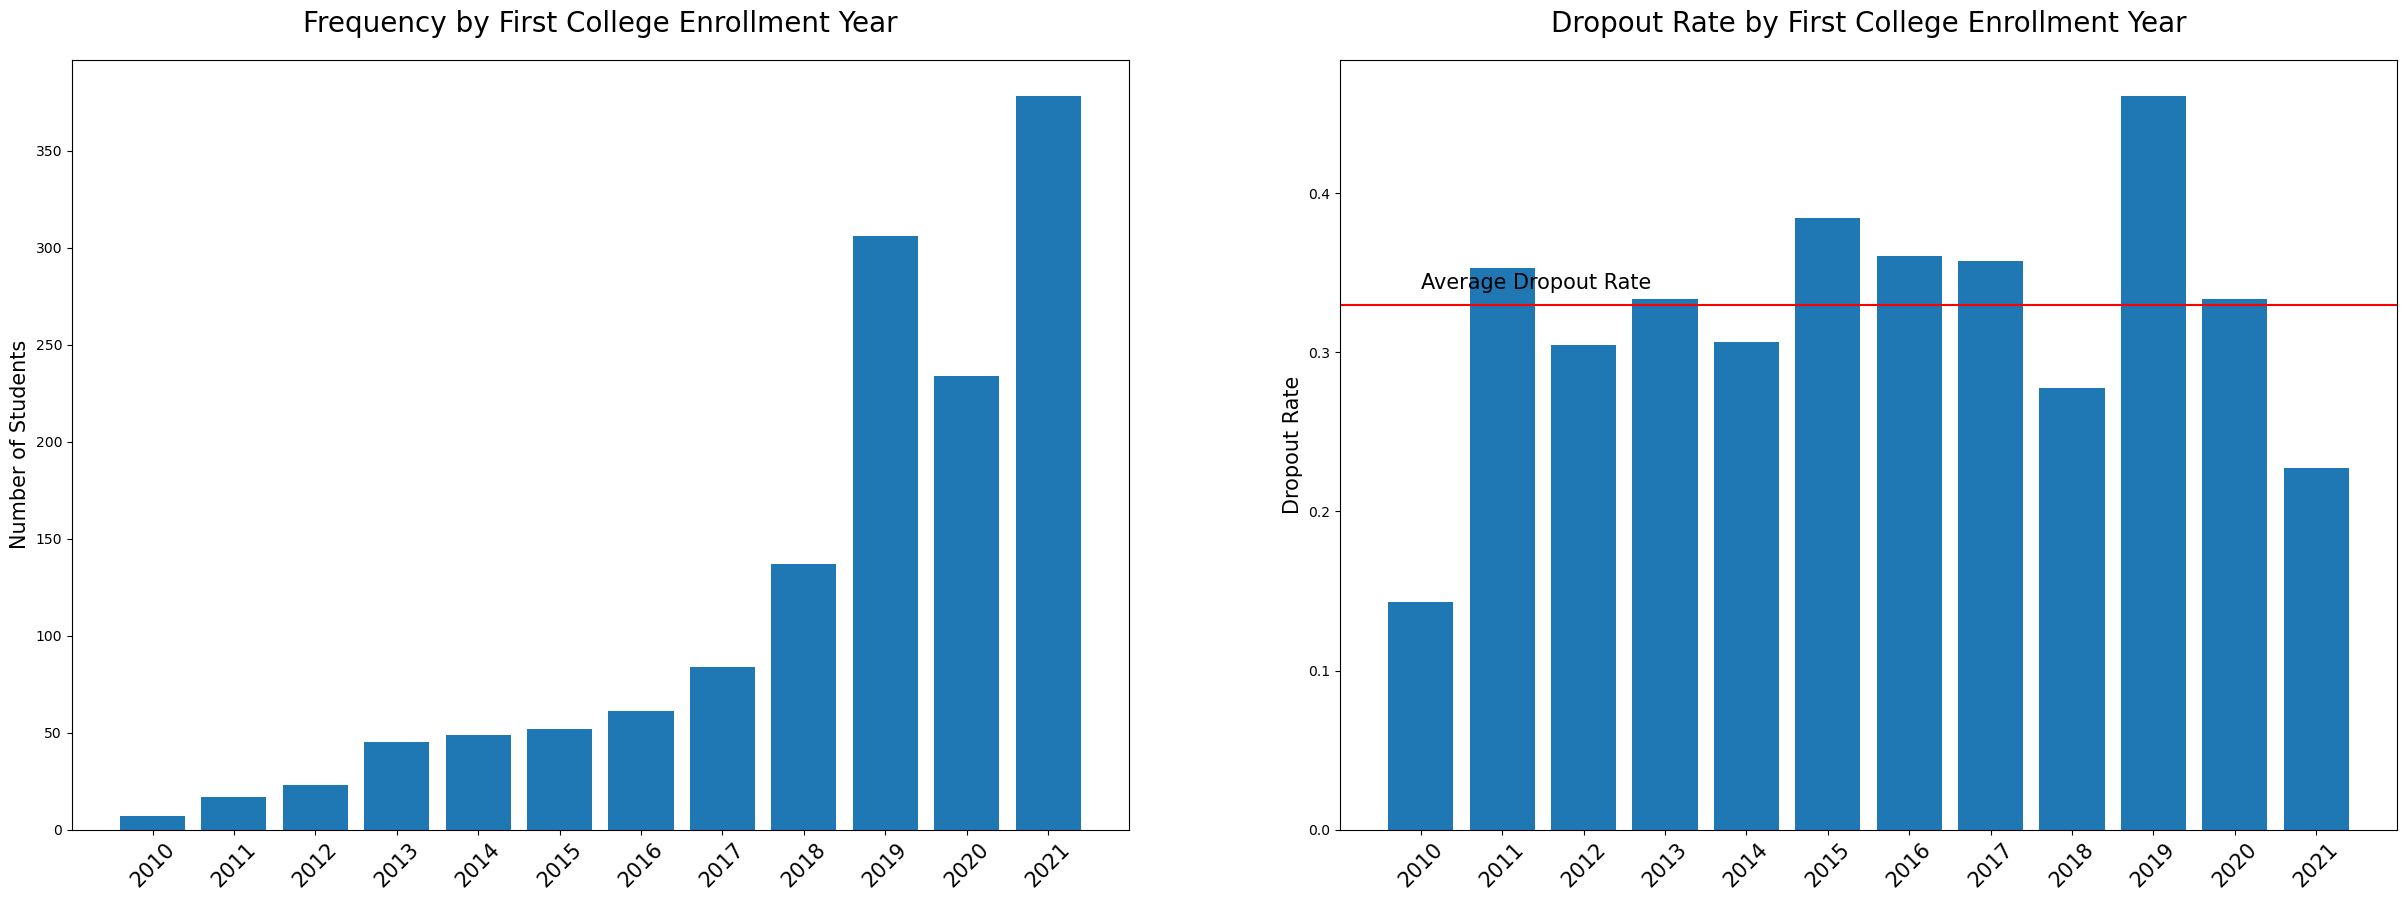

In [97]:
fCEYCount = pd.DataFrame(df.groupby("firstCollegeEnrollmentYear")['persistIndicator'].agg('count')).reset_index()
fCEYAvg = pd.DataFrame(df.groupby("firstCollegeEnrollmentYear")['persistIndicator'].agg('mean')).reset_index()

fCEYCount['firstCollegeEnrollmentYear'] = fCEYCount['firstCollegeEnrollmentYear'].astype(str)
fCEYAvg['firstCollegeEnrollmentYear'] = fCEYAvg['firstCollegeEnrollmentYear'].astype(str)

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,fCEYCount['firstCollegeEnrollmentYear'],fCEYCount.persistIndicator,"Frequency by First College Enrollment Year")
histCatVariablesNonPersistenceRate(1,fCEYAvg['firstCollegeEnrollmentYear'],fCEYAvg.persistIndicator,"Dropout Rate by First College Enrollment Year")

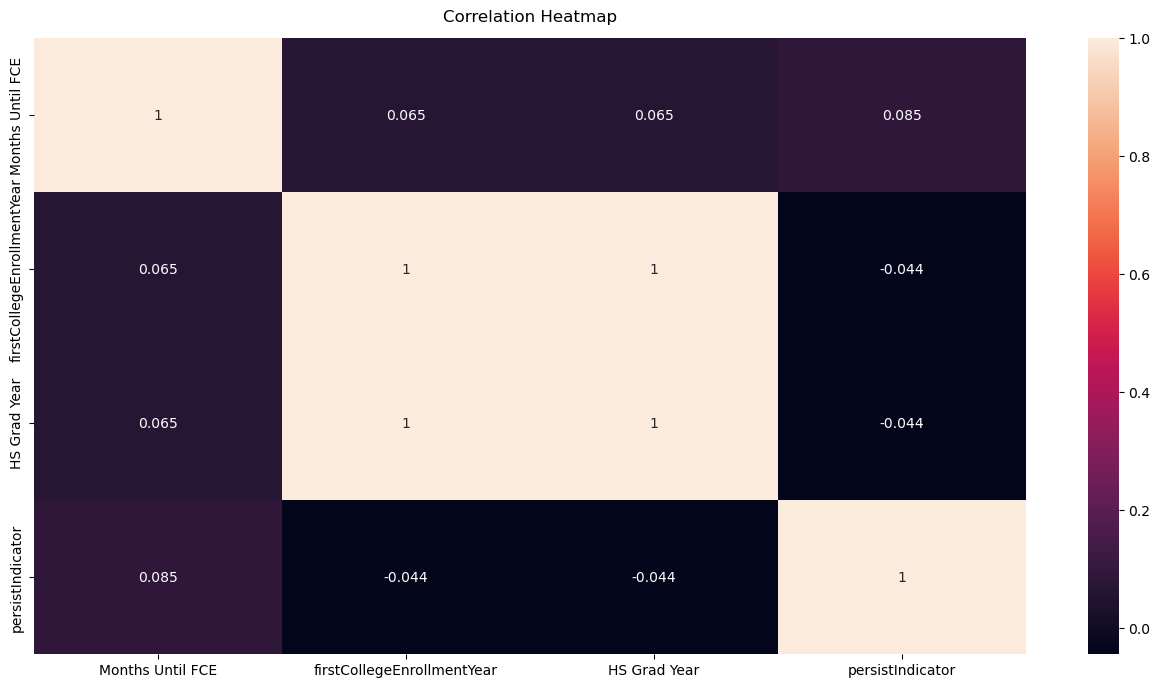

In [98]:
#Review the correlation between 'Months Since HS Grad Date','firstCollegeEnrollmentYear' and 'HS Grad Year'
plt.figure(figsize=(16,8)) 
heatmap = sns.heatmap(df[['Months Until FCE','firstCollegeEnrollmentYear','HS Grad Year','persistIndicator']].corr(), annot = True);
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### Summary of Findings for <u>Months Until FCE</u> and <u>First College Enrollment Date</u>
- Both 'Months Until FCE' and 'First College Enrollment Date' are correlated with the target.
- However, there is complete overlap between the information provided by HS Grade Year and firstCollegeEnrollmentYear variables in our dataset, as we only have records of students who started college in the fall immediately after graduating high school in June. As previously discussed, students who began college in 2019 experienced a higher dropout rate due to the Covid pandemic. Although we will not exclude any records due to Covid, we may consider conducting separate analysis of the Covid period as we gather more data in the future.
- Students with no gap after high school graduation attended the summer program offered by colleges. Therefore, 'Months Until FCE' may be a good predictor for persistence.

<u>Action</u>:

- Keep 'Months Until FCE' 
- Drop 'First College Enrollment Date'

#### 'First College Name'

In [99]:
df_colleges = pd.DataFrame(df['First College Name'].unique().tolist(), columns=['College Names'])
df_colleges.to_csv('data/unique_colleges.csv', index=False)

In [100]:
df_colleges.shape

(64, 1)

- There are students who attend 64 different colleges located in the Bay Area, as well as colleges outside the Bay Area but still within California, and colleges located outside of California. 
- It is worth noting that students who leave the Bay Area may have limited access to resources provided by 10,000 Degrees and may consequently have a higher likelihood of dropping out during their second year of college.

In [101]:
#Utilized the Chat-GPT search function to add location information to the colleges in the dataset.
df_collegesLocation = pd.read_csv('data/unique_colleges - Location.csv')
df_collegesLocation.tail()
df_collegesLocation.shape

,First College Name,County,State,College Location
59,Feather River Community College,Plumas County,California,Outside Bay Area
60,Lane Community College,Lane County,Oregon,Outside California
61,Altierus Career College- San Francisco,San Francisco County,California,Outside Bay Area
62,El Camino College,Los Angeles County,California,Outside Bay Area
63,Heald College - San Francisco,San Francisco County,California,Outside Bay Area


(64, 4)

In [102]:
#Merge df with College Location to get the College Location
df = pd.merge(left = df, right = df_collegesLocation[['First College Name','College Location']], on = 'First College Name', how = 'left')
df.head()

,Updated ID,High School,HS Grad Year,HS Grad Date,Months Since HS Grad Date,Program Participation,Dual Enrolled,Gender,Race Ethnicity,% of scholarships not accepted,Transfer status,2-yr/4-yr start,HS Region,# of scholarships since 2015,First College Enrollment Date,Months Until FCE,First College Name,First College Type,Highest Degree Earned,Highest Degree College Name,Highest Degree Date,First Cert Date,First 2-Year Degree Date,First 4-Year Degree Date,First Advanced Degree Date,2-Year College First Enrollment Date,Months Since First 2-Yr Enrollment,2-Year Degree Date,4-Year Degree Prior to 2-Year Enrollment,4-Year College First Enrollment Date,Months Since First 4-Yr Enrollment,4-Year Degree Date,Time from HS grad to bachelors,Enrollment Indicator,Latest enrollment,Persistence Indicator,Completion Indicator,Associate Completion Indicator,Bachelors Completion Indicator,Retention Indicator,persistIndicator,HSRating2,ESL,ECCA,Institute,Meritus,Success,Scholarship,successScholarship,successScholarshipParticipant,dualEnrolled,sex,percScholarshipNotAccepted,percScholarshipAccepted,percScholarshipAcceptedBinned,percScholarshipAcceptedTemp,race,hsRegion,numScholarships,numScholarshipsString,fCEBinned,firstCollegeEnrollmentYear,College Location
0,5,San Rafael High School,2019,2019-06-01,38,"Scholarship post 2015, Institute, Success",No,Female,Hispanic/Latino/a/x,-83%,No,2-Year,Marin,3.0,2019-08-19,2.580645,College Of Marin,2-Year,HS,NaN,NaT,NaT,NaT,NaT,NaT,2019-08-19,39.0,NaT,No,NaT,NaN,NaT,NaN,Yes,20190819,No,No,No,Ineligible,No,1,3,0,0,1,0,1,1,Success with Scholarship,2,0,0,-83.0,17.0,"[10.0, 20.0)",17.0,4,3,3.0,3.0,"[1, 5)",2019,Bay Area - Marin
1,13,Novato High School,2021,2021-06-01,14,"Scholarship post 2015, METAS",No,Female,Hispanic/Latino/a/x,-100%,No,2-Year,Marin,1.0,2021-08-16,2.483871,Santa Rosa Junior College,2-Year,HS,NaN,NaT,NaT,NaT,NaT,NaT,2021-08-16,15.0,NaT,No,NaT,NaN,NaT,NaN,Yes,20220822,Yes,No,Ineligible,Ineligible,No,0,6,1,0,0,0,0,1,No Success but Scholarship,1,0,0,-100.0,0.0,"[0.0, 10.0)",0.0,4,3,1.0,1.0,"[1, 5)",2021,Bay Area - Sonoma
2,15,Novato High School,2020,2020-06-01,26,"Scholarship post 2015, Success, METAS",No,Male,Hispanic/Latino/a/x,-50%,No,2-Year,Marin,2.0,2020-08-17,2.516129,Santa Rosa Junior College,2-Year,HS,NaN,NaT,NaT,NaT,NaT,NaT,2020-08-17,27.0,NaT,No,NaT,NaN,NaT,NaN,Yes,20210816,No,No,Ineligible,Ineligible,No,1,6,1,0,0,0,1,1,Success with Scholarship,2,0,1,-50.0,50.0,"[50.0, 60.0)",50.0,4,3,2.0,2.0,"[1, 5)",2020,Bay Area - Sonoma
3,18,Novato High School,2019,2019-06-01,38,"Scholarship post 2015, Institute, Success",No,Male,Asian,-34%,Transfer,2-Year,Marin,3.0,2019-08-19,2.580645,Santa Rosa Junior College,2-Year,HS,NaN,NaT,NaT,NaT,NaT,NaT,2019-08-19,39.0,NaT,No,2022-09-21,2.0,NaT,NaN,Yes,20220921,Yes,No,No,Ineligible,Yes,0,6,0,0,1,0,1,1,Success with Scholarship,2,0,1,-34.0,66.0,"[60.0, 70.0)",66.0,6,3,3.0,3.0,"[1, 5)",2019,Bay Area - Sonoma
4,20,Novato High School,2019,2019-06-01,38,"Scholarship post 2015, Institute, Success, METAS",No,Female,Hispanic/Latino/a/x,-17%,Transfer,2-Year,Marin,3.0,2019-08-19,2.580645,Santa Rosa Junior College,2-Year,HS,NaN,NaT,NaT,NaT,NaT,NaT,2019-08-19,39.0,NaT,No,2022-08-29,3.0,NaT,NaN,Yes,20220829,Yes,No,No,Ineligible,Yes,0,6,1,0,1,0,1,1,Success with Scholarship,2,0,0,-17.0,83.0,"[80.0, 90.0)",83.0,4,3,3.0,3.0,"[1, 5)",2019,Bay Area - Sonoma


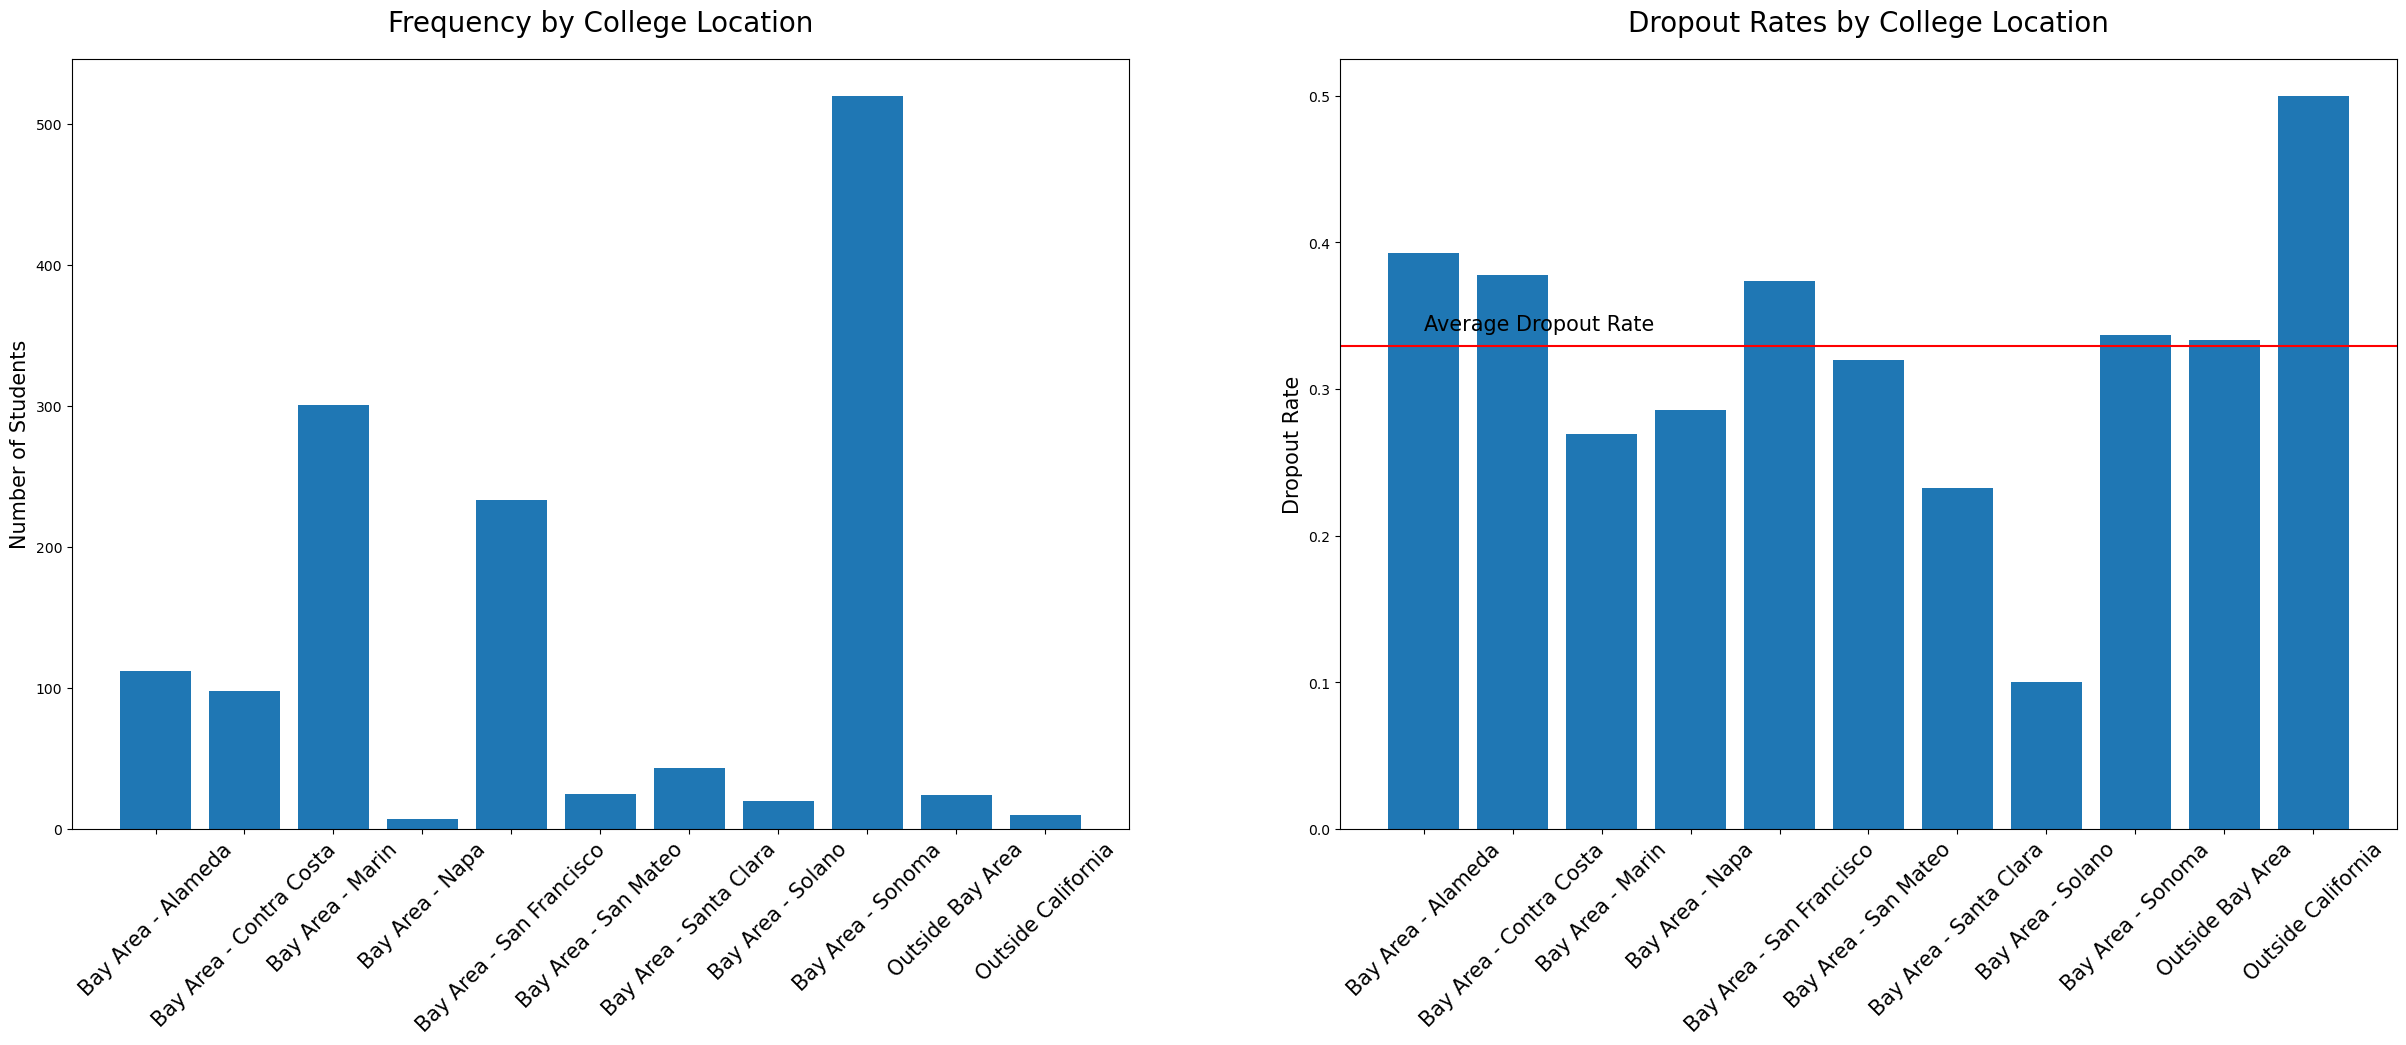

In [103]:
collegeCount = pd.DataFrame(df.groupby("College Location")['persistIndicator'].agg('count')).reset_index()
collegeAvg = pd.DataFrame(df.groupby("College Location")['persistIndicator'].agg('mean')).reset_index()

fig, ax = plt.subplots(1,2, figsize = (30, 10))
histCatVariablesCount(0,collegeCount['College Location'],collegeCount.persistIndicator,"Frequency by College Location")
histCatVariablesNonPersistenceRate(1,collegeAvg['College Location'],collegeAvg.persistIndicator,"Dropout Rates by College Location")

In [104]:
pd.DataFrame(df.groupby("College Location")['persistIndicator'].agg(['count','mean'])).reset_index().sort_values(by = 'mean',ascending = True).rename(columns = {"count": "Count","mean":"Dropout Rate"}).round(3)

,College Location,Count,Dropout Rate
7,Bay Area - Solano,20,0.100
6,Bay Area - Santa Clara,43,0.233
2,Bay Area - Marin,301,0.269
3,Bay Area - Napa,7,0.286
5,Bay Area - San Mateo,25,0.320
9,Outside Bay Area,24,0.333
8,Bay Area - Sonoma,520,0.337
4,Bay Area - San Francisco,233,0.373
1,Bay Area - Contra Costa,98,0.378
0,Bay Area - Alameda,112,0.393


In [105]:
#Map college region to numeric values based on drop-out rate
collegeRegionDict = {'Bay Area - Solano':1,
'Bay Area - Santa Clara':2,
'Bay Area - Marin':3,
'Bay Area - Napa':4,
'Bay Area - San Mateo':5,
'Outside Bay Area':6,
'Bay Area - Sonoma':7,
'Bay Area - San Francisco':8,
'Bay Area - Contra Costa':9,
'Bay Area - Alameda':10,
'Outside California':11
}

df['collegeRegion'] =df['College Location'].map(collegeRegionDict)

#### Summary of Findings for <u>First College Name</u>
- Students who attend colleges located outside of California are at a higher risk of dropping out, compared to students who attend colleges within the state. On the other hand, students who remain in California but move away from the Bay Area exhibit a moderate level of risk in terms of persisting to their second year of college.

<u>Action</u>:

- Keep "collegeRegion" for development

## Are students who move after high school more likely to drop out of college?

In [106]:
#Map variable to the clean county name
collegeRegionDict = {'Bay Area - Solano':'Solano',
'Bay Area - Santa Clara':'Santa Clara',
'Bay Area - Marin':'Marin',
'Bay Area - Napa':'Napa',
'Bay Area - San Mateo':'San Mateo',
'Outside Bay Area':'Outside Bay Area',
'Bay Area - Sonoma':'Sonoma',
'Bay Area - San Francisco':'SF Region',
'Bay Area - Contra Costa':'Contra Costa',
'Bay Area - Alameda':'Alameda',
'Outside California':'Outside California'
}

df['collegeRegion2'] =df['College Location'].map(collegeRegionDict)

In [107]:
#Check to see if there is the overlap between HS Grad Year and HS Grad Date
pd.pivot_table(df, index= 'HS Region', columns = 'collegeRegion2', aggfunc = 'count')['Updated ID'].replace({np.nan:0}).round(0).astype(int).replace({0:""})

collegeRegion2,Alameda,Contra Costa,Marin,Napa,Outside Bay Area,Outside California,SF Region,San Mateo,Santa Clara,Solano,Sonoma
HS Region,,,,,,,,,,,
Contra Costa,1,56,3,,,,,,11,,
Marin,8,6,294,,6,2,5,5,17,,193
Napa,85,2,,,,,,,,,2
Other,5,9,2,1,7,3,1,3,8,1,1
SF Region,4,3,1,1,,,226,10,1,,2
Santa Clara,1,20,,5,,,1,5,2,19,
Sonoma,8,2,1,,11,5,,2,4,,322


In [108]:
#Ceate an indicator to identify students who have moved after high school: 0-> Stayed, 1-> Moved out
df['movedAfterHighSchool'] = df.apply(lambda x: 0 if x['HS Region'] == x['collegeRegion2'] else 1, axis = 1)
df[['HS Region','collegeRegion2','movedAfterHighSchool']]

,HS Region,collegeRegion2,movedAfterHighSchool
0,Marin,Marin,0
1,Marin,Sonoma,1
2,Marin,Sonoma,1
3,Marin,Sonoma,1
4,Marin,Sonoma,1
...,...,...,...
1388,Sonoma,Sonoma,0
1389,Marin,Sonoma,1
1390,Marin,Outside Bay Area,1
1391,Marin,Marin,0


In [109]:
df.groupby('movedAfterHighSchool')['persistIndicator'].agg(['count','mean']).rename(columns = {"count": "Count","mean":"Dropout Rate"}).round(3)

,Count,Dropout Rate
movedAfterHighSchool,,
0,900,0.326
1,493,0.337


#### Summary of Findings for <u>movedAfterHighSchool</u>
- Students who attend college in a different county after high school have a slightly higher likelihood of dropping out of college.

<u>Action</u>:

- Keep "movedAfterHighSchool" for development

#### 'First College Type'

In [110]:
df['First College Type'].value_counts()

2-Year              1392
Less than 2-Year       1
Name: First College Type, dtype: int64

There is no new information in this variable. We will not include it in the development dataset.

#### Highest Degree College Name

In [111]:
df['Highest Degree College Name'].value_counts(normalize = False,dropna = False)

NaN    1393
Name: Highest Degree College Name, dtype: int64

Variable has all missing values. We will drop this variable.

#### Development Sample

After discussions with 10,000 Degrees, we agreed to use the following variables for the first phase of the model development effort.

In [112]:
modelingVarList = [
'HSRating2',
'ESL',
'ECCA',
'Institute',
'successScholarshipParticipant',
'dualEnrolled',
'sex',
'race',
'hsRegion',
'Months Until FCE',
'collegeRegion',
'movedAfterHighSchool',
'persistIndicator']

renameDictionary = {
    'HSRating2': 'HSRating',
    'ESL':'ESL',
    'ECCA':'HSProgram',
    'Institute':'SummerBeforeHS',
    'successScholarshipParticipant':'SuccessScholarship',
    'dualEnrolled':'DualEnrollment',
    'sex':'Gender',
    'race':'Race',
    'hsRegion':'HSRegion',
    'Months Until FCE':'TimeUntilFCE',
    'collegeRegion':'CollegeRegion',
    'movedAfterHighSchool':'MovedAfterHS',
    'persistIndicator':'persistIndicator'
}

df = df[modelingVarList].rename(columns = renameDictionary)
df.head()
df.shape

,HSRating,ESL,HSProgram,SummerBeforeHS,SuccessScholarship,DualEnrollment,Gender,Race,HSRegion,TimeUntilFCE,CollegeRegion,MovedAfterHS,persistIndicator
0,3,0,0,1,2,0,0,4,3,2.580645,3,0,1
1,6,1,0,0,1,0,0,4,3,2.483871,7,1,0
2,6,1,0,0,2,0,1,4,3,2.516129,7,1,1
3,6,0,0,1,2,0,1,6,3,2.580645,7,1,0
4,6,1,0,1,2,0,0,4,3,2.580645,7,1,0


(1393, 13)

In [113]:
#Write the final file to a csv to be used in the other notebooks.
df.to_csv('data/DataForHSStudentsFor2YearCollege.csv',index = False)